# Human activity recognition from Kinect data


In [ ]:
#importation of python modules

import glob
from scipy.signal import resample
import math 
import scipy
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import statistics
from sklearn.model_selection import KFold
from scipy import signal
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from sklearn import svm
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score


## Importation of the Data

 Thet Dataset is made from 10 folders: each folder corresponds to a different action. The ten actions are: walk, standup, sitdown, pickup, wavehands, carry, claphands, pull, push and throw.  There are 10 subjects, each subject performs each action twice. In this way, for every action we have 20 experiments. Since the experiments have a different number of frames, all the data are resampled with 30 frames which sums up the whole trajectory of the movement. The different actions are described through the 3D coordinates of 20 skeleton joints: hip center, spine, shoulder center, head, L/ R shoulder, L/ R elbow, L/ R wrist, L/ R hand, L/ R hip, L/ R knee, L/ R angle and L/ R foot.

In [ ]:
def Resamplesmooth(data, max_exp, window_size):
    
    indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=window_size)
    df_new = pd.DataFrame()
    for i in range(60): 
        y = data.loc[:,i]
        f = signal.resample(y, max_exp)
        f_conc = np.concatenate([f])
        df_new[i] = f_conc  
        x = np.array(df_new[i])
        smooth_data = pd.Series(x).rolling(window=indexer, min_periods=1).mean()
        f_conc = np.concatenate([smooth_data])
        df_new[i] = f_conc 
    return df_new

The number of resamples and the size of the window for the avarage mean are defined

In [ ]:
samples=30
meanV = 5 

We memorize all the experiment in a dictionary of dataFrame where each element indicates an experiment

**Walk Data** 


In [ ]:
walk = {}
for idx, f in enumerate(glob.iglob('Data2\walk\*.csv'), 1):
    walk[idx] = pd.read_csv(f, header=None)
    walk[idx]= Resamplesmooth(walk[idx], samples, meanV)

**StandUp Data**

In [ ]:
standUp = {}
for idx, f in enumerate(glob.iglob('Data2\standup\*.csv'), 1):
    standUp[idx] = pd.read_csv(f, header=None)
    standUp[idx]= Resamplesmooth(standUp[idx], samples, meanV)

**SitDown data**

In [ ]:
sitDown = {}
for idx, f in enumerate(glob.iglob('Data2\sitdown\*.csv'), 1):
    sitDown[idx] = pd.read_csv(f, header=None)
    sitDown[idx]= Resamplesmooth(sitDown[idx], samples, meanV)
    

**PickUp data**

In [ ]:
pickUp = {}
for idx, f in enumerate(glob.iglob('Data2\pickup\*.csv'), 1):
    pickUp[idx] = pd.read_csv(f, header=None)
    pickUp[idx]= Resamplesmooth(pickUp[idx], samples, meanV)

**Wavehands Data**

In [ ]:
wavehands = {}
for idx, f in enumerate(glob.iglob('Data2\wavehands\*.csv'), 1):
    wavehands[idx] = pd.read_csv(f, header=None)
    wavehands[idx]= Resamplesmooth(wavehands[idx], samples, meanV)

**Carry Data**

In [ ]:
carry = {}
for idx, f in enumerate(glob.iglob('Data2\carry\*.csv'), 1):
    carry[idx] = pd.read_csv(f, header=None)
    carry[idx]= Resamplesmooth(carry[idx], samples, meanV)

**ClapHands Data**

In [ ]:
claphands = {}
for idx, f in enumerate(glob.iglob('Data2\claphands\*.csv'), 1):
    claphands[idx] = pd.read_csv(f, header=None)
    claphands[idx]= Resamplesmooth(claphands[idx], samples, meanV)

**Pull Data**

In [ ]:
pull = {}
for idx, f in enumerate(glob.iglob('Data2\pull\*.csv'), 1):
    pull[idx] = pd.read_csv(f, header=None)
    pull[idx]= Resamplesmooth(pull[idx], samples, meanV)

**Push Data**

In [ ]:
push = {}
for idx, f in enumerate(glob.iglob('Data2\push\*.csv'), 1):
    push[idx] = pd.read_csv(f, header=None)
    push[idx]= Resamplesmooth(push[idx], samples, meanV)
    

**Throw Data**

In [ ]:
throw = {}
for idx, f in enumerate(glob.iglob('Data2\Throw\*.csv'), 1):
    throw[idx] = pd.read_csv(f, header=None)
    throw[idx]= Resamplesmooth(throw[idx], samples, meanV)

An example of dataset is shown:

In [ ]:
walk[1]

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,0.722989,-0.119856,2.010159,0.731239,-0.054486,1.996217,0.758743,0.271126,1.937458,0.677228,...,1.970714,0.779466,-0.507134,1.982400,0.874279,-0.898232,2.020262,0.792063,-0.935426,1.995991
1,0.713957,-0.124237,2.006730,0.719765,-0.060245,1.992219,0.736704,0.258536,1.931399,0.655351,...,1.968503,0.774289,-0.500115,1.986571,0.886482,-0.886876,2.010029,0.806244,-0.927313,1.988696
2,0.633501,-0.128954,2.018547,0.636925,-0.065922,2.004298,0.642921,0.249206,1.946665,0.566309,...,1.982598,0.700375,-0.502894,2.013431,0.841250,-0.873452,2.021469,0.765500,-0.918045,2.004661
3,0.570521,-0.135440,2.026323,0.572797,-0.072302,2.012772,0.574808,0.245489,1.960523,0.503835,...,1.991736,0.637549,-0.517058,2.029356,0.809806,-0.858420,2.028335,0.737546,-0.902804,2.013717
4,0.534918,-0.139763,2.028948,0.537456,-0.075206,2.016195,0.543860,0.251777,1.968979,0.475517,...,1.994227,0.594043,-0.534305,2.033776,0.785418,-0.843243,2.031013,0.716788,-0.883036,2.016881
5,0.478272,-0.138214,2.037720,0.481745,-0.071038,2.025785,0.496245,0.269673,1.982710,0.426740,...,2.002393,0.526833,-0.546133,2.048769,0.715177,-0.831307,2.047647,0.651682,-0.865748,2.035170
6,0.387136,-0.133046,2.055229,0.391481,-0.062488,2.044064,0.413122,0.293654,2.004409,0.340637,...,2.020124,0.430856,-0.550776,2.083138,0.595782,-0.824178,2.083540,0.536669,-0.855101,2.073565
7,0.300698,-0.129873,2.072152,0.305587,-0.056083,2.061540,0.332075,0.313554,2.024244,0.257223,...,2.039321,0.353334,-0.549231,2.125010,0.484273,-0.820127,2.124542,0.425988,-0.850207,2.114989
8,0.239921,-0.130777,2.083635,0.244848,-0.055052,2.073326,0.273145,0.322127,2.037226,0.198465,...,2.056504,0.317534,-0.541121,2.165204,0.416446,-0.817431,2.158995,0.356612,-0.850193,2.147273
9,0.178419,-0.132466,2.095636,0.182504,-0.056739,2.085582,0.207593,0.319754,2.050293,0.136943,...,2.077771,0.287193,-0.528532,2.205984,0.369364,-0.816156,2.189506,0.309268,-0.855119,2.175462


## Funtion definition

distance function calcultes the Euclidean distance between two points in 3D space

In [ ]:
def distance(p,q):
    """distance function calculates the Euclidian distance in 3D space"""
    
    d = np.power((p[:,0]-q[:,0]),2) + np.power((p[:,1]-q[:,1]),2)+ np.power((p[:,2]-q[:,2]),2)
    return np.power(d, 0.5)  

Trisarea Calculation function calculates the area between 3 points in a 3D space. There are two ways to calculate the area. The first one is a vector method wich uses the cross product between two distance vectors: 0.5||pqxpr|| where p,q,r are the 3 points. The second method uses the semi-perimeter.

In [ ]:
def TriseaCalculation(p, q, r):
    """TriseaCalculation function calculates the area of a triangle in 3D space"""
    a = distance(p,q)
    c = distance(p,r)
    b = distance(q,r)
    s = (a + b + c) / 2
    # calculate the area
    area = np.power((s*(s-a)*(s-b)*(s-c)), 0.5)
    return area

featureExtractorTime function extracts the time evolution of the features along each frame. It basically calculates the features at the frame t_i and puts them into a unique line-vector. This solution is implemented by ourselves in order to compare the performance of some different classification algorithms. The Datasets must have the same number of frames. For this reason the Dataset must be pre-processed and resampled in order to have an equal number of values for each movement.

In [ ]:
def featureExtractorTime(data):
    """distanceExtractor takes as an input the Dataset for a mocement and calculates 11 distances between joints.
    Finally put all the features of each frames in the same vector which corresponds to a row. The output 
    is a Dataframe where each row is a different experiment of the same action"""
    
    #Initialization of the Dataframe
    
    outD = pd.DataFrame()
    outT = pd.DataFrame()
    outAll = pd.DataFrame()
    
    for j in data:    
        
        #separation of the body joints
        hipcenter=data[j].to_numpy()[:,0:3]
        spine=data[j].to_numpy()[:,3:6]
        shouldercenter=data[j].to_numpy()[:,6:9]
        head=data[j].to_numpy()[:,9:12]
        Lshoulder=data[j].to_numpy()[:,12:15]
        Rshoulder=data[j].to_numpy()[:,15:18]
        Lelbow=data[j].to_numpy()[:,18:21]
        Relbow=data[j].to_numpy()[:,21:24]
        Lwrist=data[j].to_numpy()[:,24:27]
        Rwrist=data[j].to_numpy()[:,27:30]
        Lhand=data[j].to_numpy()[:,30:33]
        Rhand=data[j].to_numpy()[:,33:36]
        Lhip=data[j].to_numpy()[:,36:39]
        Rhip=data[j].to_numpy()[:,39:42]
        Lknee=data[j].to_numpy()[:,42:45]
        Rknee=data[j].to_numpy()[:,45:48]
        Lancle=data[j].to_numpy()[:,48:51]
        Rancle=data[j].to_numpy()[:,51:54]
        Lfoot=data[j].to_numpy()[:,54:57]
        Rfoot=data[j].to_numpy()[:,57:60]
        
        #scale factor, distance between head and central hip
        #to be more usefull it should be the real high of the person who makes the movements
        f = np.mean(distance(head, hipcenter))
        
         
        #calculation of 11 distances normalized by the scale factor (distance between hipcenter and head)
        distance1 = distance(head, hipcenter)/f; 
        distance2= distance (Lelbow, hipcenter)/f;
        distance3= distance (Relbow,hipcenter)/f;
        distance4= distance (Lhand, hipcenter)/f;
        distance5= distance (Rhand, hipcenter)/f;
        distance6= distance (Lknee, hipcenter)/f;
        distance7= distance (Rknee, hipcenter)/f;
        distance8= distance (Lfoot, hipcenter)/f;
        distance9= distance (Rfoot, hipcenter)/f;
        distance10= distance (Lhip, hipcenter)/f;
        distance11= distance (Rhip, hipcenter)/f;
        distance12 = distance(Lancle,hipcenter)/f
        distance13 = distance(Rancle, hipcenter)/f            
        distance14 = distance(Lhand, Rhand)/f;
        distance15= distance (Lfoot, Rfoot)/f;   
        distance16= distance(Lknee,Lelbow)/f;            
        distance17= distance (Rknee, Relbow)/f;            
        distance18= distance (Rancle, Lhand)/f;
        distance19= distance (Lancle, Rhand)/f;
        distance20= distance (Lancle, Lwrist)/f;
        distance21= distance (Rancle, Rwrist)/f;
        distance22= distance (Rhand, head)/f;
        distance23= distance (Lhand, head)/f;
        distance24= distance (Lelbow, Relbow)/f;            
        distance25= distance (Rknee, Lknee)/f;     
            
        data1 = np.concatenate((distance1, distance2, distance3, distance4, distance5, distance6, distance7,
                                distance8, distance9, distance10, distance11, distance12, distance13, distance14,
                               distance15, distance16, distance17, distance18, distance19, distance20, distance21, distance22,
                               distance23, distance24, distance25))
        dataframeD = pd.DataFrame(data1*100).T
        outD = outD.append(dataframeD)
        
        #f=1  
        #Areas features
        Area1 = TriseaCalculation(Relbow, Lelbow, hipcenter)/f            
        Area2 = TriseaCalculation(Rknee, Lknee, hipcenter)/f
        Area3 = TriseaCalculation(Relbow, Lknee, hipcenter)/f            
        Area4 = TriseaCalculation(Lelbow, Lknee, hipcenter)/f
        Area5 = TriseaCalculation(Rfoot, Lfoot, hipcenter)/f
        Area6 = TriseaCalculation(Lhand, Rhand, hipcenter)/f            
        Area7 = TriseaCalculation(Rknee, Lknee, hipcenter)/f
        Area8 = TriseaCalculation(Lwrist, Rwrist, hipcenter)/f  
        Area9 = TriseaCalculation(Relbow, Rhip, Rknee)/f
        Area10 = TriseaCalculation(Rknee, Lhip, Lfoot)/f
        Area11 = TriseaCalculation(hipcenter, Lelbow, Lhand)/f
        Area12 = TriseaCalculation(Rfoot, Rhand, Lhand)/f
        Area13 = TriseaCalculation(Lfoot, Rhand, Lhand)/f
        Area14 = TriseaCalculation(Lknee, Rhip, Rfoot)/f
        Area15 = TriseaCalculation(Lelbow, Lhip, Lknee)/f
        Area16 = TriseaCalculation(hipcenter, Relbow, Rhand)/f
        Area17 = TriseaCalculation(Relbow, Rhip, Lknee)/f
        Area18 = TriseaCalculation(Rknee, Rhip, Rfoot)/f
        Area19 = TriseaCalculation(hipcenter, Lelbow, Lhand)/f
        Area20 = TriseaCalculation(Lfoot, Lhand, Lelbow)/f
        Area21 = TriseaCalculation(Rfoot, Rhand, Rhip)/f
        Area22 = TriseaCalculation(Lknee, Lhip, Lfoot)/f
        Area23 = TriseaCalculation(Rknee, Rhip, Rfoot)/f
        Area24 = TriseaCalculation(Lknee, Lhip, Lfoot)/f
        Area25 = TriseaCalculation(Relbow, Rhip, Rfoot)/f
        
        matrixT = np.concatenate((Area1, Area2, Area3, Area4, Area5, Area6, Area7, Area8, Area9, Area10,
                                Area11, Area12, Area13, Area14, Area15, Area16, Area17, Area18, Area19, Area20, Area21, Area22,
                                 Area23,Area24, Area25))
        dataframeT = pd.DataFrame(matrixT*100).T
        outT = outT.append(dataframeT)
        
        matrixAll =  np.concatenate((distance1, distance2, distance3, distance4, distance5, distance6, distance7,
                                distance8, distance9, distance10, distance11, distance12, distance13, distance14,
                               distance15, distance16, distance17, distance18, distance19, distance20, distance21, distance22,
                               distance23, distance24, distance25, Area1, Area2, Area3, Area4, Area5, Area6, Area7, Area8, Area9, Area10,
                                Area11, Area12, Area13, Area14, Area15, Area16, Area17, Area18, Area19, Area20, Area21, Area22, Area23,
                                    Area24, Area25))
        dataframeAll = pd.DataFrame(matrixAll*100).T
        outAll = outAll.append(dataframeAll)
    return outD, outT, outAll



In [ ]:
walkdist, walkTrisea, walkAll = featureExtractorTime(walk)
standist, standTrisea, standAll = featureExtractorTime(standUp)
sitdist, sitTriseat, sitAll = featureExtractorTime(sitDown)
pickdist, pickTrisea, pickAll = featureExtractorTime(pickUp)
wavehandsdist, wavehandsTrisea, wavehandsAll = featureExtractorTime(wavehands)
pushdist, pushTrisea, pushAll =  featureExtractorTime(push)
pulldist, pullTrisea, pullAll= featureExtractorTime(pull)
claphandsdist, claphandsTrisea, claphandsAll =  featureExtractorTime(claphands)
carrydist, carryTrisea, carryAll = featureExtractorTime(carry)
throwdist, throwTrisea, throwAll = featureExtractorTime(throw)

In [ ]:
walkdist

,0,1,2,3,4,5,6,7,8,9,...,740,741,742,743,744,745,746,747,748,749
0,101.750212,101.094687,100.863672,101.237733,101.938491,102.767072,103.894056,105.437701,106.990727,107.847702,...,13.630809,15.442287,16.681079,16.805484,16.251182,15.428994,14.428043,12.960882,12.089746,12.495625
0,100.231687,99.918299,99.585345,99.404155,99.412808,99.561759,99.778586,100.000696,100.177358,100.270286,...,4.771356,8.120902,13.242081,16.655373,17.567775,16.788603,16.609433,15.716736,13.901694,12.025526
0,109.365913,109.972752,109.536664,108.615081,107.189515,105.002862,102.437638,100.367159,99.133555,98.178840,...,16.050002,15.390580,14.988486,14.734517,14.424201,14.145791,14.053723,14.135819,14.323953,14.942865
0,90.083619,94.807427,100.524513,106.479386,111.078463,113.184222,112.986146,111.345840,108.854128,105.970393,...,12.723561,11.183863,10.709872,10.243601,9.406607,8.981791,11.263570,14.741029,16.243681,15.455725
0,108.071449,108.643719,108.328559,107.592920,106.531470,105.137306,103.567692,101.917661,100.112211,98.195200,...,14.918557,15.353628,15.070245,13.231982,10.670953,8.488616,7.198862,7.728361,8.498900,6.621775
0,102.913273,103.354983,103.691215,104.079726,104.473790,104.714096,104.687208,104.321834,103.541306,102.322570,...,16.372877,15.594468,15.336647,15.356103,15.008502,14.099305,14.019725,13.653798,12.612448,11.525210
0,98.861267,99.207333,99.194520,98.975777,98.537480,97.883276,97.287050,97.205972,97.951419,99.473928,...,17.131780,16.867701,17.028081,17.573543,17.405468,15.553079,15.501470,15.004630,13.151413,11.385224
0,97.987534,98.245880,98.365792,98.593523,99.162343,100.041510,101.101549,102.362366,103.841147,105.222061,...,11.443058,11.190970,12.406199,14.786522,15.862501,14.388004,14.098393,13.125295,10.994458,9.354304
0,97.185025,95.491150,93.958582,93.523542,94.167086,95.009227,95.546236,96.124219,97.135391,98.474151,...,16.015358,14.622729,12.427694,10.871709,10.961286,11.290332,11.985583,12.391488,12.115971,12.568548
0,96.717096,94.793783,93.737453,93.830438,94.811121,96.032524,97.145661,98.377381,100.009416,101.805750,...,14.329276,15.626341,16.675956,17.216283,16.914914,15.099301,14.990483,14.191973,11.532971,9.756456


## Distance Time Features 

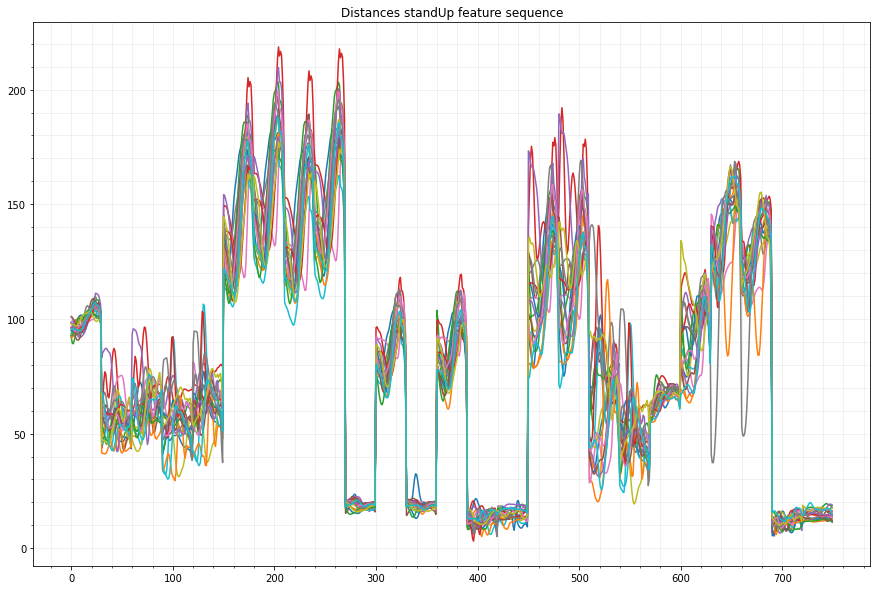

In [ ]:
plt.figure(figsize=[15,10])
plt.plot(standist.T)
plt.title('Distances standUp feature sequence')
plt.axis("on")
plt.grid(True, alpha=0.2)
plt.grid(True,which='minor', alpha=0.2)
plt.minorticks_on()
plt.savefig('standist.png', bbox_inches='tight')
plt.show()


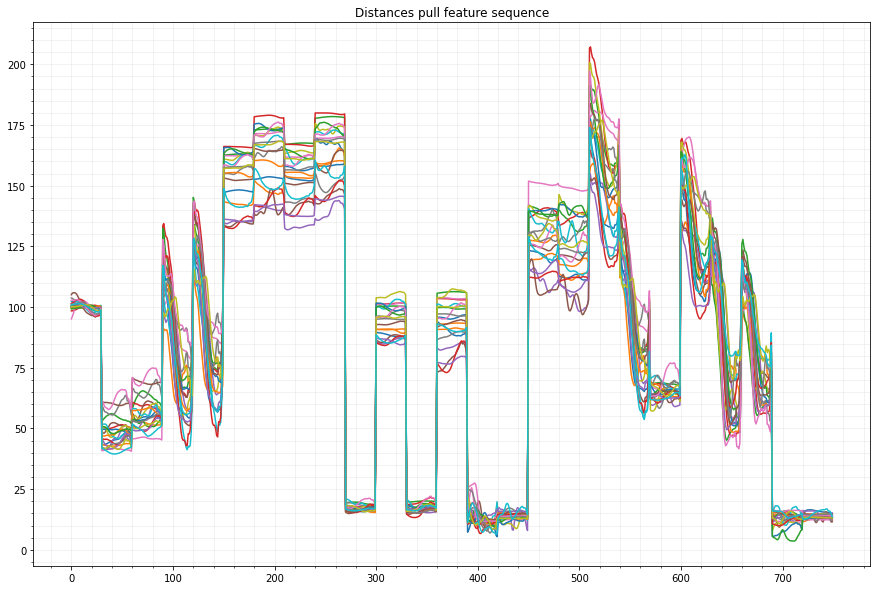

In [ ]:
plt.figure(figsize=[15,10])
plt.plot(pulldist.T)
plt.title('Distances pull feature sequence')
plt.axis("on")
plt.grid(True, alpha=0.2)
plt.grid(True,which='minor', alpha=0.2)
plt.minorticks_on()
plt.savefig('pulldist.png', bbox_inches='tight')
plt.show()

Creation of the dataFrames: only 7 actions are present.

In [ ]:

DataframeD = pd.concat([ standist, pickdist, wavehandsdist, pushdist, pulldist, claphandsdist, carrydist], ignore_index=True)
DataframeT = pd.concat([ standTrisea, pickTrisea, wavehandsTrisea, pushTrisea, pullTrisea, claphandsTrisea, carryTrisea], ignore_index=True)
DataframeAll = pd.concat([ standAll, pickAll, wavehandsAll, pushAll, pullAll, claphandsAll, carryAll], ignore_index=True)

In [ ]:
DataframeAll

,0,1,2,3,4,5,6,7,8,9,...,1490,1491,1492,1493,1494,1495,1496,1497,1498,1499
0,93.068588,94.656276,97.223005,98.910659,99.432736,99.606703,99.670367,99.000829,97.408996,95.694171,...,1.911246,1.823100,1.958431,2.292917,2.529020,2.349932,2.488618,2.409585,1.792168,0.970828
1,94.875623,94.685980,94.978869,95.131242,95.035807,95.057333,95.366816,95.690389,95.823647,95.989540,...,4.047483,3.914209,3.903704,4.003698,4.025182,3.692024,3.722485,3.616161,3.069627,2.638878
2,92.028032,89.497185,89.134811,90.629576,92.718027,94.496704,95.349309,95.090471,94.526813,94.757032,...,4.587836,5.161996,5.802003,6.492467,6.661115,5.767817,5.845552,5.565815,4.161765,1.714724
3,96.080899,94.967229,94.384728,94.072239,94.031657,94.330790,94.887218,95.515047,96.078958,96.527725,...,2.372318,0.972647,3.966240,7.284711,9.445526,9.328188,9.926512,9.312559,6.738310,2.710209
4,98.318766,97.424223,96.764103,95.803728,94.554683,93.474995,92.748000,92.222899,91.894464,91.923031,...,3.671234,2.928805,5.125812,7.300642,7.503313,5.337581,4.572100,3.418558,3.510038,8.992481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,92.257038,92.427123,93.463002,94.754405,95.830970,96.751789,97.658122,98.398293,98.850160,99.289219,...,9.913786,8.914742,9.741297,11.368793,12.791390,13.560875,13.589022,13.679519,14.247645,15.237608
136,96.301984,96.702932,97.666560,98.609148,98.961862,98.739881,98.290756,97.830871,97.601603,98.182158,...,1.371183,2.807907,2.709750,2.186361,5.235335,7.338202,10.459204,12.768226,11.410667,5.835597
137,102.463510,104.898942,107.365689,109.023471,108.946116,107.194946,104.971592,103.407732,102.560393,101.876256,...,6.864522,5.034823,4.550371,5.019646,6.993827,9.492473,12.134112,14.375064,14.813746,13.370578
138,96.953209,96.435367,96.073673,95.990587,96.065260,96.333323,97.047210,98.321723,99.950139,101.585546,...,11.433611,13.147401,12.771066,9.847742,6.274232,4.284792,3.206134,2.754068,2.767754,5.626075


In [ ]:
classZero = np.zeros(20)
classOne = np.ones(20)
classTwo = 2*np.ones(20)
classThree = 3*np.ones(20)
classFour = 4*np.ones(20)
classFive = 5*np.ones(20)
classsix = 6*np.ones(20)
classseven = 7*np.ones(20)
classEight = 8*np.ones(20)
classNine = 9*np.ones(20)

labels= np.concatenate([classZero, classOne, classTwo, classThree, classFour, classFive , classsix])
y = labels

# Distance dataFrame

In [ ]:

# split the data with 70% in each set
Xtrain, Xtest, ytrain, ytest = train_test_split(DataframeD, y, random_state=0, train_size=0.7, stratify=y)

# SELECT CLASSIFIER
model_knn  = KNeighborsClassifier(n_neighbors=5)
model_lda  = LinearDiscriminantAnalysis( store_covariance=True)
model_qda  = QuadraticDiscriminantAnalysis(store_covariance=True)
model_tree = DecisionTreeClassifier()
model_gnb  = GaussianNB()
clf = svm.SVC(kernel='poly', degree=8)

# FIT the model on one set of data
model_knn.fit(Xtrain, ytrain)
model_lda.fit(Xtrain, ytrain)
model_qda.fit(Xtrain, ytrain)
model_tree.fit(Xtrain, ytrain)
model_gnb.fit(Xtrain, ytrain)
clf.fit(Xtrain, ytrain)

# TEST evaluate the model on the second set of data
ytest_pred_knn  = model_knn.predict(Xtest)
ytest_pred_lda  = model_lda.predict(Xtest)
ytest_pred_qda  = model_qda.predict(Xtest)
ytest_pred_tree = model_tree.predict(Xtest)
ytest_pred_gnb  = model_gnb.predict(Xtest)
ytest_pred_svm = clf.predict(Xtest)

c:\users\lorenzo\appdata\local\programs\python\python39\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


The warming message is because LDA and QDA, like regression techniques involves computing a matrix inversion, which is inaccurate if the determinant is close to 0 (i.e. two or more variables are almost a linear combination of each other).
It is not good since it could make the estimated coefficients impossible to interpret. The correlation problem will be solved with the dimensionality reduction

In [ ]:
# Classification Report
print('KNN:')
print(classification_report(ytest, ytest_pred_knn))
print('LDA:')
print(classification_report(ytest, ytest_pred_lda))
print('QDA:')
print(classification_report(ytest, ytest_pred_qda))
print('TREE:')
print(classification_report(ytest, ytest_pred_tree))
print('GNB:')
print(classification_report(ytest, ytest_pred_gnb))
print('SVM:')
print(classification_report(ytest, ytest_pred_svm))


# Cross Validarion Scores
scores_knn  = cross_val_score(model_knn,  Xtest, ytest)
scores_lda  = cross_val_score(model_lda,  Xtest, ytest)
scores_qda  = cross_val_score(model_qda,  Xtest, ytest)
scores_tree = cross_val_score(model_tree, Xtest, ytest)
scores_gnb  = cross_val_score(model_gnb,  Xtest, ytest)
scores_svm  = cross_val_score(clf,  Xtest, ytest)



KNN:
              precision    recall  f1-score   support

         0.0       0.75      1.00      0.86         6
         1.0       1.00      0.67      0.80         6
         2.0       1.00      1.00      1.00         6
         3.0       1.00      1.00      1.00         6
         4.0       1.00      1.00      1.00         6
         5.0       1.00      0.83      0.91         6
         6.0       0.86      1.00      0.92         6

    accuracy                           0.93        42
   macro avg       0.94      0.93      0.93        42
weighted avg       0.94      0.93      0.93        42

LDA:
              precision    recall  f1-score   support

         0.0       0.86      1.00      0.92         6
         1.0       1.00      1.00      1.00         6
         2.0       1.00      1.00      1.00         6
         3.0       1.00      1.00      1.00         6
         4.0       1.00      1.00      1.00         6
         5.0       0.86      1.00      0.92         6
         6.0  

c:\users\lorenzo\appdata\local\programs\python\python39\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\users\lorenzo\appdata\local\programs\python\python39\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\users\lorenzo\appdata\local\programs\python\python39\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\users\lorenzo\appdata\local\programs\python\python39\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\users\lorenzo\appdata\local\programs\python\python39\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [ ]:
# Cross Validation 
print("Accuracy KNN: %0.2f (+/- %0.2f)" % (scores_knn.mean(), scores_knn.std() ))
print("Accuracy LDA: %0.2f (+/- %0.2f)" % (scores_lda.mean(), scores_lda.std() ))
print("Accuracy QDA: %0.2f (+/- %0.2f)" % (scores_qda.mean(), scores_qda.std() ))
print("Accuracy TREE: %0.2f (+/- %0.2f)" % (scores_tree.mean(), scores_tree.std() ))
print("Accuracy GNB: %0.2f (+/- %0.2f)" % (scores_gnb.mean(), scores_gnb.std() ))
print("Accuracy SVM:%0.2f (+/- %0.2f)" % (scores_svm.mean(), scores_svm.std()))



Accuracy KNN: 0.86 (+/- 0.05)
Accuracy LDA: 0.95 (+/- 0.06)
Accuracy QDA: 0.47 (+/- 0.17)
Accuracy TREE: 0.76 (+/- 0.07)
Accuracy GNB: 0.85 (+/- 0.15)
Accuracy SVM:0.83 (+/- 0.07)


Text(0.5, 1.0, 'KNN')

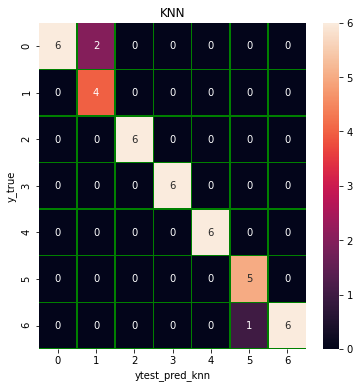

In [ ]:
# Confusion Matrix Plot
cm1 = confusion_matrix(ytest_pred_knn, ytest)
cm2 = confusion_matrix(ytest_pred_lda, ytest)
cm3 = confusion_matrix(ytest_pred_qda, ytest)
cm4 = confusion_matrix(ytest_pred_tree, ytest)
cm5 = confusion_matrix(ytest_pred_gnb, ytest)
cm6 = confusion_matrix(ytest_pred_svm, ytest)

plt.figure(figsize=(6, 6))
sns.heatmap(cm1,annot = True,linewidths=0.5,linecolor="green",fmt = ".0f")
plt.xlabel("ytest_pred_knn")
plt.ylabel("y_true")
plt.title('KNN')


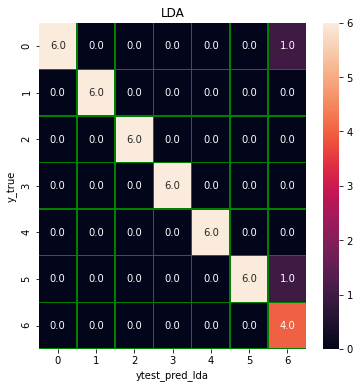

In [ ]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm2,annot = True,linewidths=0.5,linecolor="green",fmt = ".01f")
plt.xlabel("ytest_pred_lda")
plt.ylabel("y_true")
plt.title('LDA')
plt.savefig('CM_LDA_TDD.png', bbox_inches='tight')

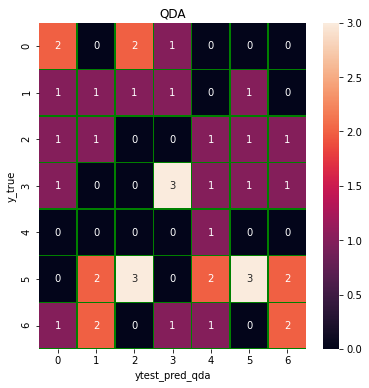

In [ ]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm3,annot = True,linewidths=0.5,linecolor="green",fmt = ".0f")
plt.xlabel("ytest_pred_qda")
plt.ylabel("y_true")
plt.title('QDA')
plt.savefig('QDA.png', bbox_inches='tight')
plt.show()




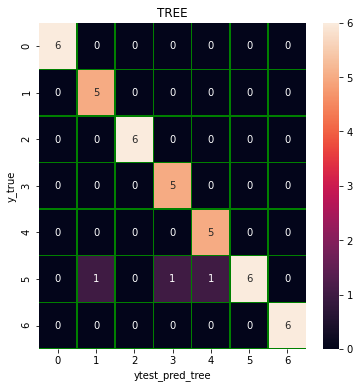

In [ ]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm4,annot = True,linewidths=0.5,linecolor="green",fmt = ".0f")
plt.xlabel("ytest_pred_tree")
plt.ylabel("y_true")
plt.title('TREE')
plt.show()

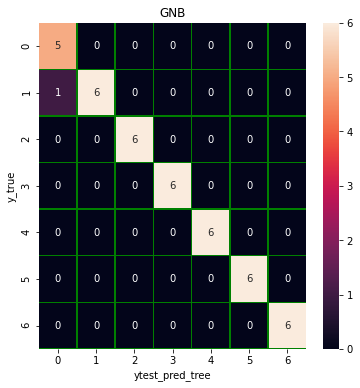

In [ ]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm5,annot = True,linewidths=0.5,linecolor="green",fmt = ".0f")
plt.xlabel("ytest_pred_tree")
plt.ylabel("y_true")
plt.title('GNB')
plt.savefig('GNB.png', bbox_inches='tight')
plt.show()


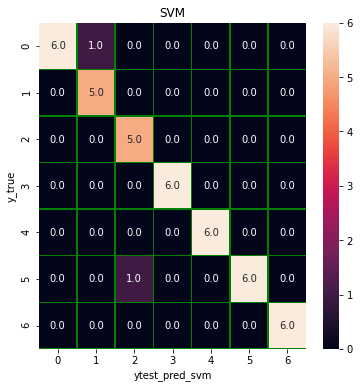

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm6,annot = True,linewidths=0.5,linecolor="green",fmt = ".01f")
plt.xlabel("ytest_pred_svm")
plt.ylabel("y_true")
plt.title('SVM')
plt.show()
plt.savefig('CM_SVM1.png', bbox_inches='tight')

KFOLD test in order to verify the rubustness of the accuracy result

In [ ]:
kf = KFold(n_splits=10)
CS= cross_val_score(model_lda, DataframeD, y, cv=kf, scoring='accuracy')
CS

array([0.92857143, 1.        , 0.85714286, 1.        , 1.        ,
       1.        , 1.        , 0.64285714, 0.78571429, 0.42857143])

In [ ]:
np.mean(CS)

0.8642857142857144

The ROC  curve  is  a  graphical  plot  that  illustrates  the diagnostic  ability  of  a  binary  classifier  system  as  its discrimination threshold varies. The  ROC  curve  is  created  by  plotting  the  true  positive rate (TPR) against the false positive rate (FPR) at various threshold  settings.  The  true-positive  rate  is  also  known as  sensitivity.  Usually  it  is  a  parameter  evaluation  for binary  classification.  In  our  implementation,  a  more complex  version  is  implemented.  A  ’plot-multiclass-roc’ function is implemented. Basically, it calculates the standard  ROC  trajectories  for  each  class.

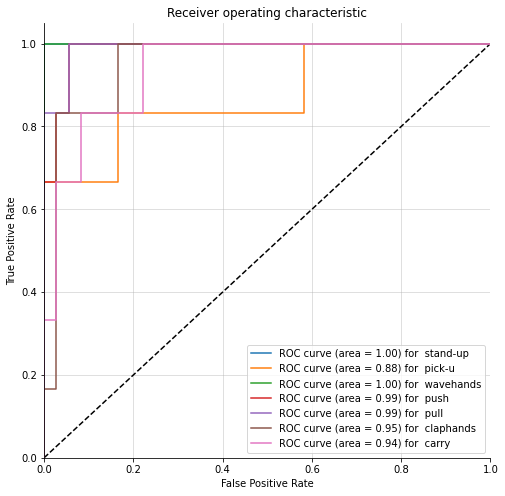

In [ ]:
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(8, 8)):
    y_score = clf.decision_function(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    act= ['stand-up ','pick-u', 'wavehands', 'push', 'pull', 'claphands', 'carry']
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %.02f) for  %s' % (roc_auc[i], act[i]))
    ax.legend(loc="best")
    ax.grid(alpha=.5)
    sns.despine()
    plt.savefig('ROC', bbox_inches='tight')
    plt.show()

plot_multiclass_roc(model_lda, Xtest, ytest, n_classes=7, figsize=(8, 8))

# Trisarea dataFrame

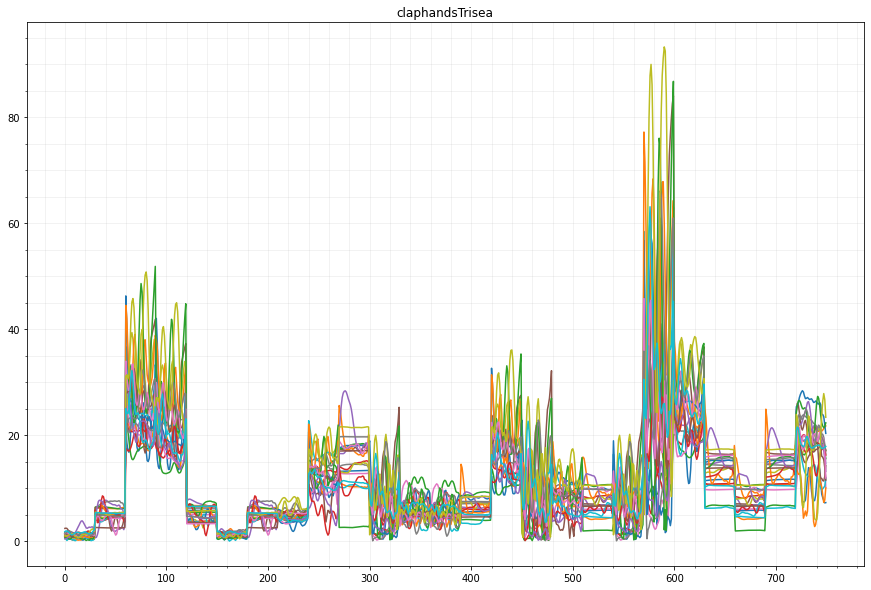

In [ ]:
plt.figure(figsize=[15,10])
plt.plot(claphandsTrisea.T)
plt.title('claphandsTrisea')
plt.axis("on")
plt.grid(True, alpha=0.2)
plt.grid(True,which='minor', alpha=0.2)
plt.minorticks_on()
plt.show()

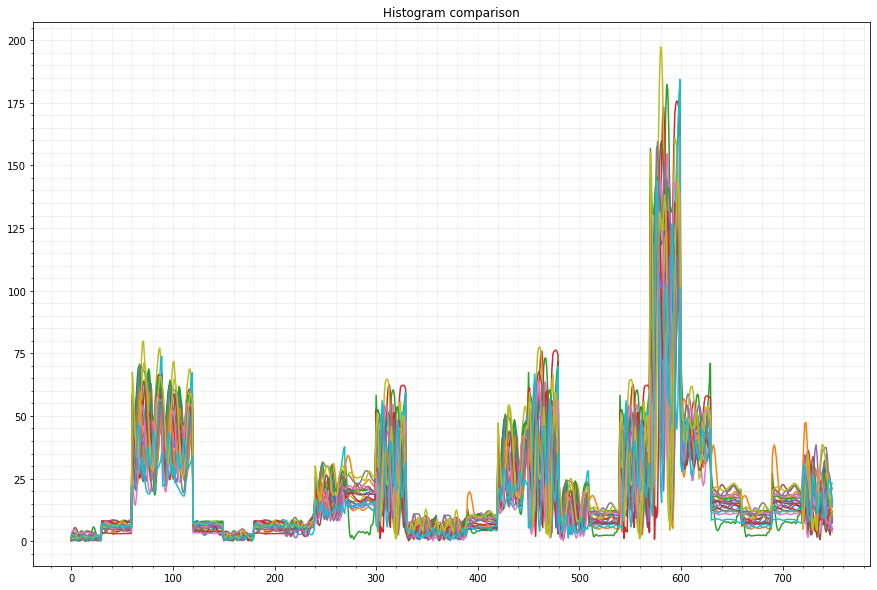

In [ ]:
plt.figure(figsize=[15,10])
plt.plot(wavehandsTrisea.T)
plt.title('Histogram comparison')
plt.axis("on")
plt.grid(True, alpha=0.2)
plt.grid(True,which='minor', alpha=0.2)
plt.minorticks_on()
plt.show()

In [ ]:
# split the data with 70% in each set
Xtrain, Xtest, ytrain, ytest = train_test_split(DataframeT, y, random_state=0, train_size=0.7,  stratify=y)

# SELECT CLASSIFIER
model_knn  = KNeighborsClassifier(n_neighbors=5)
model_lda  = LinearDiscriminantAnalysis( store_covariance=True)
model_qda  = QuadraticDiscriminantAnalysis(store_covariance=True)
model_tree = DecisionTreeClassifier()
model_gnb  = GaussianNB()
clf = svm.SVC(kernel='poly', degree=8)

# FIT the model on one set of data
model_knn.fit(Xtrain, ytrain)
model_lda.fit(Xtrain, ytrain)
model_qda.fit(Xtrain, ytrain)
model_tree.fit(Xtrain, ytrain)
model_gnb.fit(Xtrain, ytrain)
clf.fit(Xtrain, ytrain)

# TEST evaluate the model on the second set of data
ytest_pred_knn  = model_knn.predict(Xtest)
ytest_pred_lda  = model_lda.predict(Xtest)
ytest_pred_qda  = model_qda.predict(Xtest)
ytest_pred_tree = model_tree.predict(Xtest)
ytest_pred_gnb  = model_gnb.predict(Xtest)
ytest_pred_svm = clf.predict(Xtest)

c:\users\lorenzo\appdata\local\programs\python\python39\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [ ]:
# Classification Report
print('KNN:')
print(classification_report(ytest, ytest_pred_knn))
print('LDA:')
print(classification_report(ytest, ytest_pred_lda))
print('QDA:')
print(classification_report(ytest, ytest_pred_qda))
print('TREE:')
print(classification_report(ytest, ytest_pred_tree))
print('GNB:')
print(classification_report(ytest, ytest_pred_gnb))
print('SVM:')
print(classification_report(ytest, ytest_pred_svm))


# Cross Validarion Scores
scores_knn  = cross_val_score(model_knn,  Xtest, ytest)
scores_lda  = cross_val_score(model_lda,  Xtest, ytest)
scores_qda  = cross_val_score(model_qda,  Xtest, ytest)
scores_tree = cross_val_score(model_tree, Xtest, ytest)
scores_gnb  = cross_val_score(model_gnb,  Xtest, ytest)
scores_svm  = cross_val_score(clf,  Xtest, ytest)


KNN:
              precision    recall  f1-score   support

         0.0       0.86      1.00      0.92         6
         1.0       1.00      0.67      0.80         6
         2.0       1.00      0.67      0.80         6
         3.0       0.75      1.00      0.86         6
         4.0       1.00      1.00      1.00         6
         5.0       0.75      1.00      0.86         6
         6.0       0.80      0.67      0.73         6

    accuracy                           0.86        42
   macro avg       0.88      0.86      0.85        42
weighted avg       0.88      0.86      0.85        42

LDA:
              precision    recall  f1-score   support

         0.0       0.86      1.00      0.92         6
         1.0       1.00      0.67      0.80         6
         2.0       1.00      0.83      0.91         6
         3.0       1.00      1.00      1.00         6
         4.0       1.00      1.00      1.00         6
         5.0       0.60      1.00      0.75         6
         6.0  

c:\users\lorenzo\appdata\local\programs\python\python39\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\users\lorenzo\appdata\local\programs\python\python39\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\users\lorenzo\appdata\local\programs\python\python39\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\users\lorenzo\appdata\local\programs\python\python39\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\users\lorenzo\appdata\local\programs\python\python39\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [ ]:
# Cross Validation 
print("Accuracy KNN: %0.2f (+/- %0.2f)" % (scores_knn.mean(), scores_knn.std() ))
print("Accuracy LDA: %0.2f (+/- %0.2f)" % (scores_lda.mean(), scores_lda.std() ))
print("Accuracy QDA: %0.2f (+/- %0.2f)" % (scores_qda.mean(), scores_qda.std() ))
print("Accuracy TREE: %0.2f (+/- %0.2f)" % (scores_tree.mean(), scores_tree.std() ))
print("Accuracy GNB: %0.2f (+/- %0.2f)" % (scores_gnb.mean(), scores_gnb.std() ))
print("Accuracy SVM:%0.2f (+/- %0.2f)" % (scores_svm.mean(), scores_svm.std() ))



Accuracy KNN: 0.62 (+/- 0.09)
Accuracy LDA: 0.81 (+/- 0.10)
Accuracy QDA: 0.24 (+/- 0.23)
Accuracy TREE: 0.42 (+/- 0.11)
Accuracy GNB: 0.84 (+/- 0.12)
Accuracy SVM:0.71 (+/- 0.13)


Text(0.5, 1.0, 'KNN')

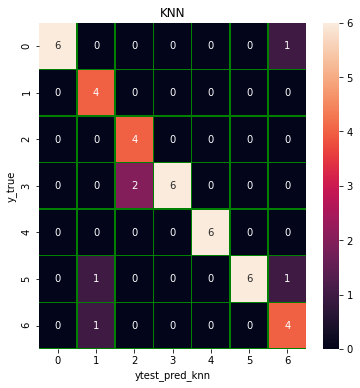

In [ ]:
# Confusion Matrix Plot
cm1 = confusion_matrix(ytest_pred_knn, ytest)
cm2 = confusion_matrix(ytest_pred_lda, ytest)
cm3 = confusion_matrix(ytest_pred_qda, ytest)
cm4 = confusion_matrix(ytest_pred_tree, ytest)
cm5 = confusion_matrix(ytest_pred_gnb, ytest)
cm6 = confusion_matrix(ytest_pred_svm, ytest)

plt.figure(figsize=(6, 6))
sns.heatmap(cm1,annot = True,linewidths=0.5,linecolor="green",fmt = ".0f")
plt.xlabel("ytest_pred_knn")
plt.ylabel("y_true")
plt.title('KNN')


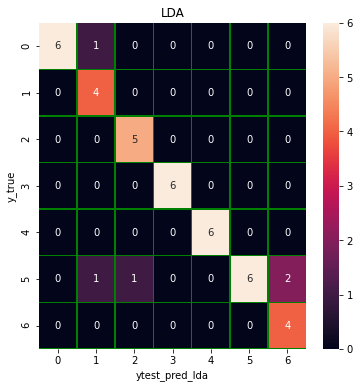

In [ ]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm2,annot = True,linewidths=0.5,linecolor="green",fmt = ".0f")
plt.xlabel("ytest_pred_lda")
plt.ylabel("y_true")
plt.title('LDA')
plt.savefig('CM_LDA_1.png', bbox_inches='tight')

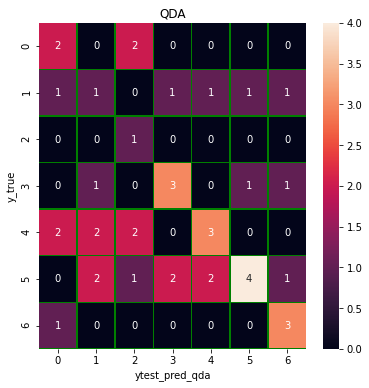

In [ ]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm3,annot = True,linewidths=0.5,linecolor="green",fmt = ".0f")
plt.xlabel("ytest_pred_qda")
plt.ylabel("y_true")
plt.title('QDA')
plt.savefig('QDA.png', bbox_inches='tight')
plt.show()

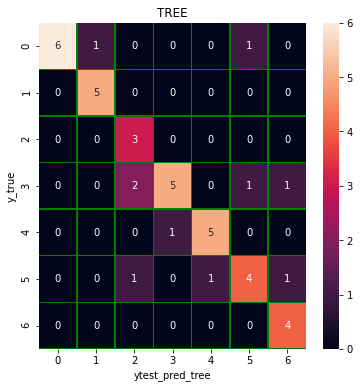

In [ ]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm4,annot = True,linewidths=0.5,linecolor="green",fmt = ".0f")
plt.xlabel("ytest_pred_tree")
plt.ylabel("y_true")
plt.title('TREE')
plt.show()

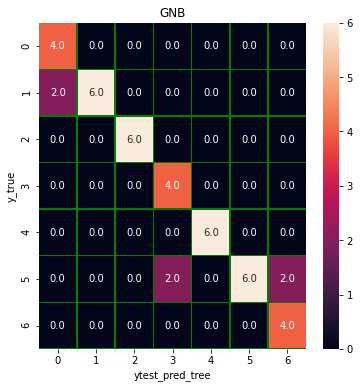

In [ ]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm5,annot = True,linewidths=0.5,linecolor="green",fmt = ".01f")
plt.xlabel("ytest_pred_tree")
plt.ylabel("y_true")
plt.title('GNB')
plt.savefig('GNB.png', bbox_inches='tight')
plt.show()


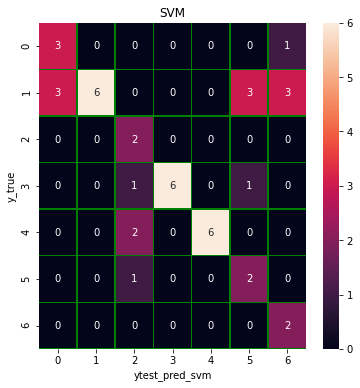

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm6,annot = True,linewidths=0.5,linecolor="green",fmt = ".0f")
plt.xlabel("ytest_pred_svm")
plt.ylabel("y_true")
plt.title('SVM')
plt.show()
plt.savefig('CM_SVM1.png', bbox_inches='tight')

In [ ]:
kf = KFold(n_splits=10)
A= cross_val_score(model_lda, DataframeT, y, cv=kf, scoring='accuracy')
A

array([0.92857143, 0.71428571, 0.85714286, 1.        , 0.78571429,
       1.        , 1.        , 0.92857143, 0.64285714, 0.14285714])

In [ ]:
np.mean(A)

0.8

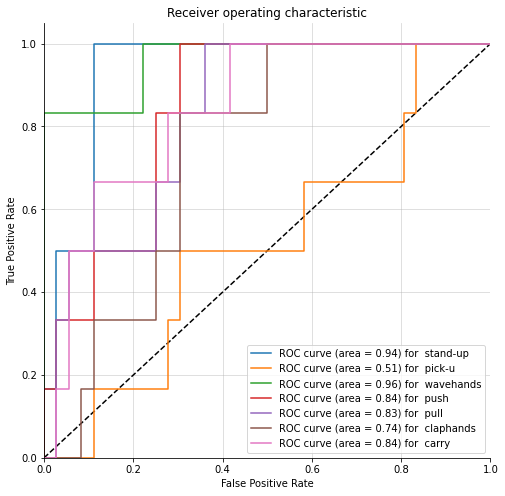

In [ ]:
plot_multiclass_roc(model_qda, Xtest, ytest, n_classes=7, figsize=(8, 8))

# Complete dataFrame

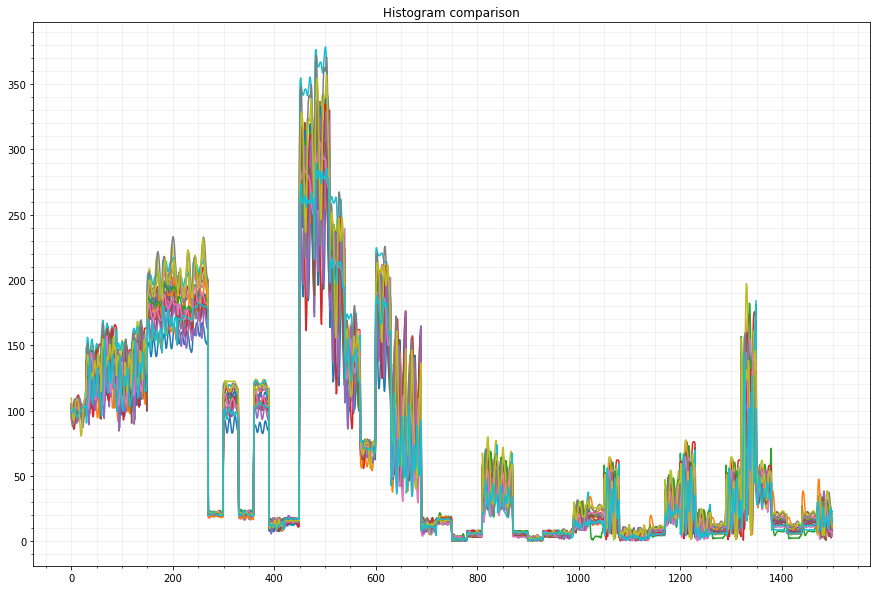

In [ ]:
plt.figure(figsize=[15,10])
plt.plot(wavehandsAll.T)
plt.title('Histogram comparison')
plt.axis("on")
plt.grid(True, alpha=0.2)
plt.grid(True,which='minor', alpha=0.2)
plt.minorticks_on()
plt.show()

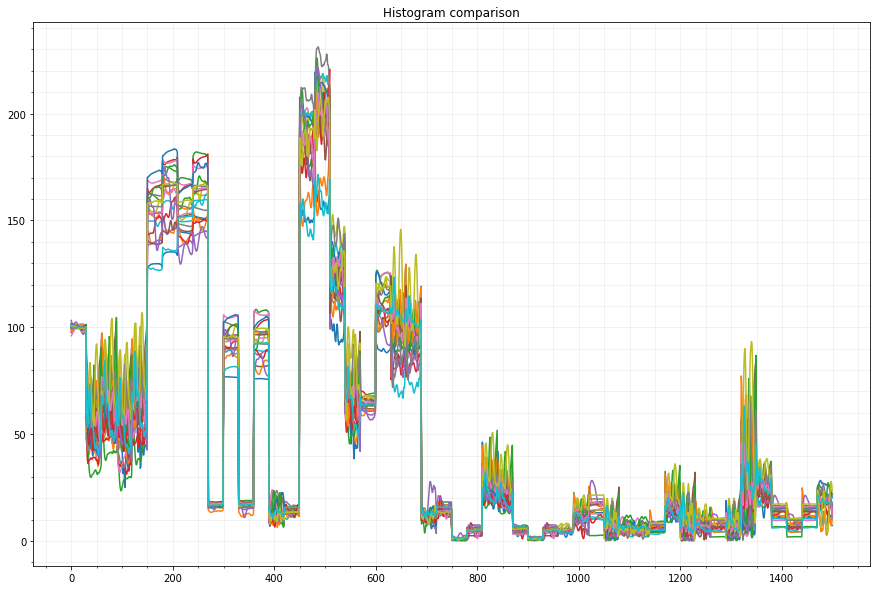

In [ ]:
plt.figure(figsize=[15,10])
plt.plot(claphandsAll.T)
plt.title('Histogram comparison')
plt.axis("on")
plt.grid(True, alpha=0.2)
plt.grid(True,which='minor', alpha=0.2)
plt.minorticks_on()
plt.show()

In [ ]:
# split the data with 70% in each set
Xtrain, Xtest, ytrain, ytest = train_test_split(DataframeAll, y, random_state=0, train_size=0.7, stratify=y)

# SELECT CLASSIFIER
model_knn  = KNeighborsClassifier(n_neighbors=5)
model_lda  = LinearDiscriminantAnalysis( store_covariance=True)
model_qda  = QuadraticDiscriminantAnalysis(store_covariance=True)
model_tree = DecisionTreeClassifier()
model_gnb  = GaussianNB()
clf = svm.SVC(kernel='poly', degree=8)

# FIT the model on one set of data
model_knn.fit(Xtrain, ytrain)
model_lda.fit(Xtrain, ytrain)
model_qda.fit(Xtrain, ytrain)
model_tree.fit(Xtrain, ytrain)
model_gnb.fit(Xtrain, ytrain)
clf.fit(Xtrain, ytrain)

# TEST evaluate the model on the second set of data
ytest_pred_knn  = model_knn.predict(Xtest)
ytest_pred_lda  = model_lda.predict(Xtest)
ytest_pred_qda  = model_qda.predict(Xtest)
ytest_pred_tree = model_tree.predict(Xtest)
ytest_pred_gnb  = model_gnb.predict(Xtest)
ytest_pred_svm = clf.predict(Xtest)

c:\users\lorenzo\appdata\local\programs\python\python39\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [ ]:
# Classification Report
print('KNN:')
print(classification_report(ytest, ytest_pred_knn))
print('LDA:')
print(classification_report(ytest, ytest_pred_lda))
print('QDA:')
print(classification_report(ytest, ytest_pred_qda))
print('TREE:')
print(classification_report(ytest, ytest_pred_tree))
print('GNB:')
print(classification_report(ytest, ytest_pred_gnb))
print('SVM:')
print(classification_report(ytest, ytest_pred_svm))


# Cross Validarion Scores
scores_knn  = cross_val_score(model_knn,  Xtest, ytest)
scores_lda  = cross_val_score(model_lda,  Xtest, ytest)
scores_qda  = cross_val_score(model_qda,  Xtest, ytest)
scores_tree = cross_val_score(model_tree, Xtest, ytest)
scores_gnb  = cross_val_score(model_gnb,  Xtest, ytest)
scores_svm  = cross_val_score(clf,  Xtest, ytest)

KNN:
              precision    recall  f1-score   support

         0.0       0.86      1.00      0.92         6
         1.0       1.00      0.83      0.91         6
         2.0       1.00      1.00      1.00         6
         3.0       1.00      1.00      1.00         6
         4.0       1.00      1.00      1.00         6
         5.0       1.00      0.83      0.91         6
         6.0       0.86      1.00      0.92         6

    accuracy                           0.95        42
   macro avg       0.96      0.95      0.95        42
weighted avg       0.96      0.95      0.95        42

LDA:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         6
         1.0       1.00      0.83      0.91         6
         2.0       1.00      1.00      1.00         6
         3.0       1.00      1.00      1.00         6
         4.0       1.00      1.00      1.00         6
         5.0       0.75      1.00      0.86         6
         6.0  

c:\users\lorenzo\appdata\local\programs\python\python39\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\users\lorenzo\appdata\local\programs\python\python39\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\users\lorenzo\appdata\local\programs\python\python39\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\users\lorenzo\appdata\local\programs\python\python39\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\users\lorenzo\appdata\local\programs\python\python39\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [ ]:
# Cross Validation 
print("Accuracy KNN: %0.2f (+/- %0.2f)" % (scores_knn.mean(), scores_knn.std() ))
print("Accuracy LDA: %0.2f (+/- %0.2f)" % (scores_lda.mean(), scores_lda.std() ))
print("Accuracy QDA: %0.2f (+/- %0.2f)" % (scores_qda.mean(), scores_qda.std() ))
print("Accuracy TREE: %0.2f (+/- %0.2f)" % (scores_tree.mean(), scores_tree.std() ))
print("Accuracy GNB: %0.2f (+/- %0.2f)" % (scores_gnb.mean(), scores_gnb.std() ))
print("Accuracy SVM:%0.2f (+/- %0.2f)" % (scores_svm.mean(), scores_svm.std() ))



Accuracy KNN: 0.86 (+/- 0.05)
Accuracy LDA: 0.91 (+/- 0.08)
Accuracy QDA: 0.40 (+/- 0.18)
Accuracy TREE: 0.69 (+/- 0.18)
Accuracy GNB: 0.81 (+/- 0.13)
Accuracy SVM:0.83 (+/- 0.10)


In [ ]:
scores_lda

array([0.77777778, 1.        , 1.        , 0.875     , 0.875     ])

Text(0.5, 1.0, 'KNN')

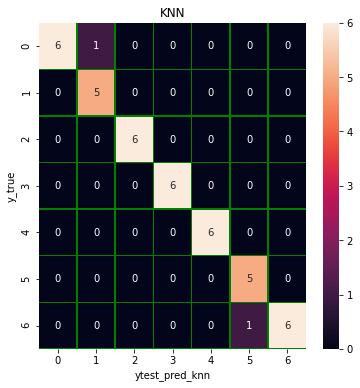

In [ ]:
# Confusion Matrix Plot
cm1 = confusion_matrix(ytest_pred_knn, ytest)
cm2 = confusion_matrix(ytest_pred_lda, ytest)
cm3 = confusion_matrix(ytest_pred_qda, ytest)
cm4 = confusion_matrix(ytest_pred_tree, ytest)
cm5 = confusion_matrix(ytest_pred_gnb, ytest)
cm6 = confusion_matrix(ytest_pred_svm, ytest)

plt.figure(figsize=(6, 6))
sns.heatmap(cm1,annot = True,linewidths=0.5,linecolor="green",fmt = ".0f")
plt.xlabel("ytest_pred_knn")
plt.ylabel("y_true")
plt.title('KNN')

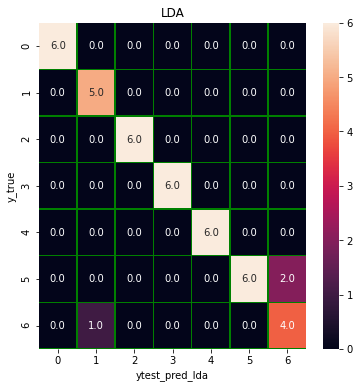

In [ ]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm2,annot = True,linewidths=0.5,linecolor="green",fmt = ".01f")
plt.xlabel("ytest_pred_lda")
plt.ylabel("y_true")
plt.title('LDA')
plt.savefig('CM_LDA_TDA.png', bbox_inches='tight')

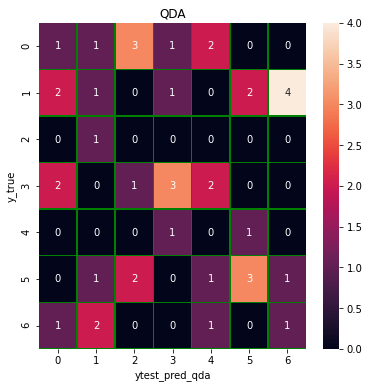

In [ ]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm3,annot = True,linewidths=0.5,linecolor="green",fmt = ".0f")
plt.xlabel("ytest_pred_qda")
plt.ylabel("y_true")
plt.title('QDA')
plt.savefig('QDA.png', bbox_inches='tight')
plt.show()

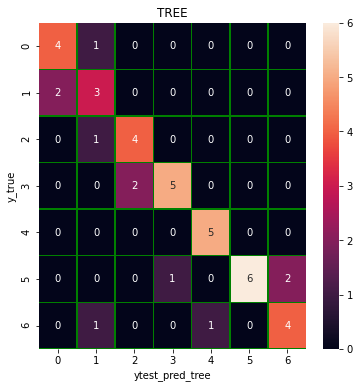

In [ ]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm4,annot = True,linewidths=0.5,linecolor="green",fmt = ".0f")
plt.xlabel("ytest_pred_tree")
plt.ylabel("y_true")
plt.title('TREE')
plt.show()

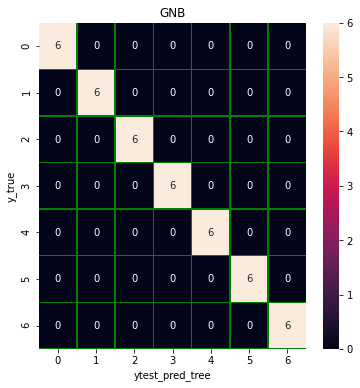

In [ ]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm5,annot = True,linewidths=0.5,linecolor="green",fmt = ".0f")
plt.xlabel("ytest_pred_tree")
plt.ylabel("y_true")
plt.title('GNB')
plt.savefig('GNB.png', bbox_inches='tight')
plt.show()

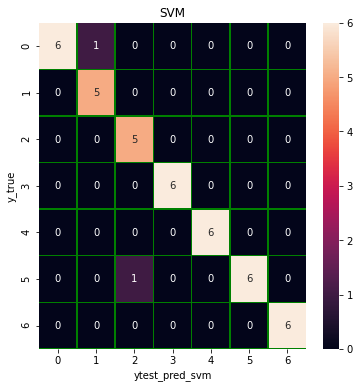

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm6,annot = True,linewidths=0.5,linecolor="green",fmt = ".0f")
plt.xlabel("ytest_pred_svm")
plt.ylabel("y_true")
plt.title('SVM')
plt.show()
plt.savefig('CM_SVM1.png', bbox_inches='tight')

In [ ]:
kf = KFold(n_splits=10)
CS= cross_val_score(model_lda, DataframeT, y, cv=kf, scoring='accuracy')
CS

array([0.92857143, 0.71428571, 0.85714286, 1.        , 0.78571429,
       1.        , 1.        , 0.92857143, 0.64285714, 0.14285714])

In [ ]:
np.mean(CS)

0.8

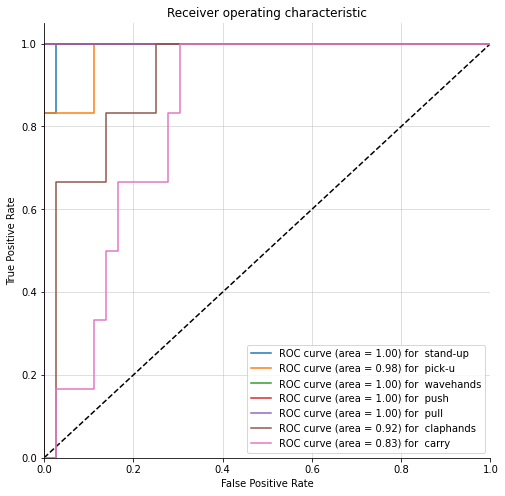

In [ ]:
plot_multiclass_roc(model_lda, Xtest, ytest, n_classes=7, figsize=(8, 8))

## PCA

In [ ]:
XDScaled = StandardScaler().fit_transform(DataframeAll)
pca = decomposition.PCA(n_components=60).fit(XDScaled)

In [ ]:
print('Explained variance = {} {} {} {}'.format(*pca.explained_variance_ratio_))
100*pca.explained_variance_ratio_.cumsum()

Explained variance = 0.30925982614431796 0.11067102250489329 0.0670303093638358 0.05972373313477239


array([30.92598261, 41.99308486, 48.6961158 , 54.66848911, 58.87663302,
       61.863641  , 64.5833337 , 66.9072227 , 68.78120249, 70.4857149 ,
       72.07847876, 73.54182184, 74.88724863, 76.07942414, 77.22048337,
       78.26667796, 79.25835207, 80.18576047, 81.05274542, 81.87873214,
       82.64426406, 83.37032085, 84.05204709, 84.71947643, 85.33114696,
       85.92037138, 86.49320218, 87.03358678, 87.5641101 , 88.05697139,
       88.54816201, 88.99709674, 89.42760173, 89.83255717, 90.22712025,
       90.61266097, 90.9974644 , 91.36360425, 91.70502354, 92.02161778,
       92.32004119, 92.61444562, 92.90513509, 93.18197709, 93.44615808,
       93.69759746, 93.93527443, 94.17287562, 94.40605419, 94.62349549,
       94.83456661, 95.03662528, 95.2360802 , 95.42327323, 95.60171473,
       95.77294805, 95.94040764, 96.10239999, 96.25548423, 96.39728423])

In [ ]:
vec = pca.components_ 
print(vec)

[[-7.30444037e-05 -4.74801856e-03 -7.77266537e-03 ...  2.21323502e-03
   3.10971342e-03  3.78723917e-03]
 [ 2.81377020e-02  2.32887652e-02  1.70825877e-02 ...  1.79677394e-02
   1.37744684e-02  9.81863059e-03]
 [-1.81039545e-02 -1.77385643e-02 -1.64938466e-02 ...  4.09320626e-02
   4.75400221e-02  5.59143344e-02]
 ...
 [-3.55948331e-03 -5.43710049e-04  3.95301299e-03 ...  2.09679156e-02
   1.90246430e-02  1.91029197e-02]
 [-2.28606576e-02  1.07413814e-02  4.59263007e-02 ...  7.07093340e-02
   6.98046139e-02  4.34828546e-02]
 [-1.21306576e-02 -2.30295793e-02 -3.31026914e-02 ... -1.32326072e-02
  -6.57411193e-03  2.08015186e-03]]


In [ ]:
Xproj = pca.transform(XDScaled) #project data to PCA space
Xreduced = Xproj[:,0:50] #keep only 50 first PC components
DataframeReduced = pd.DataFrame(Xreduced)
DataframeReduced

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-17.453110,4.373839,-6.043667,2.368267,-3.770107,-10.944684,-7.064262,-2.824399,-1.031845,6.389144,...,-2.164337,3.341079,0.195883,-1.838189,0.517760,-3.246448,2.295853,-2.225169,-2.373322,0.232399
1,-24.082013,8.146618,-11.511758,-0.764854,-8.989333,-6.585227,-3.916247,-1.527280,-2.045274,3.696733,...,0.135680,0.778737,1.447661,-0.957818,0.189014,-0.374462,0.354139,-2.023009,1.540729,0.521951
2,-10.209082,16.079415,-9.158136,-3.837991,0.632492,-6.547254,-15.676730,-4.364211,-0.857731,5.573511,...,-0.088617,0.577749,-1.165813,-2.542010,2.248373,-0.324803,0.282140,-0.258425,0.302056,-0.316080
3,0.932873,24.815901,-0.376436,-2.000756,-1.614415,-6.733034,-2.805079,1.054516,2.080734,-2.144159,...,-0.115781,-5.273204,-2.128052,2.165541,-2.426292,3.525676,-0.554002,1.393553,-1.516797,3.320879
4,-2.021593,36.964843,9.434181,-9.123727,-8.999761,0.157109,2.599158,0.486573,2.637889,-7.311431,...,-2.318994,-0.875697,0.855398,-0.405452,0.261819,2.775761,-2.228351,-0.188688,0.137552,2.991380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,-16.820880,-6.418696,14.824981,6.058479,-1.639577,-3.003283,-0.433214,1.234411,-6.245667,-1.293411,...,2.030167,-0.696184,2.599384,-2.280808,-4.006421,-1.392465,0.182129,-4.233727,3.326449,3.898870
136,-2.054603,6.193830,30.704014,0.803197,-0.495772,-2.003287,-3.047820,0.127546,-9.972938,4.458964,...,1.432437,0.215036,1.031268,3.580545,1.030266,-2.885261,-5.212801,1.036294,-1.086212,-0.595102
137,-13.838989,-1.807803,13.220423,5.614846,5.860700,-3.861311,-0.470404,4.452774,0.587227,-5.878497,...,-5.838969,-1.006902,-3.056305,-1.236360,0.604910,-2.177866,-5.750814,0.507370,2.180420,-0.880407
138,-15.652548,-2.949309,13.171678,4.170826,2.418897,-5.783056,-2.450233,2.297768,-3.773732,-2.128322,...,2.752732,2.131311,0.368818,5.410117,1.938091,-3.243294,6.134101,0.163791,4.218967,1.447605


In [ ]:
# split the data with 70% in each set
Xtrain, Xtest, ytrain, ytest = train_test_split(DataframeReduced, y, random_state=0, train_size=0.70, stratify=y)

# SELECT CLASSIFIER
model_knn  = KNeighborsClassifier(n_neighbors=5)
model_lda  = LinearDiscriminantAnalysis( store_covariance=True)
model_qda  = QuadraticDiscriminantAnalysis(store_covariance=True)
model_tree = DecisionTreeClassifier()
model_gnb  = GaussianNB()
clf = svm.SVC()

# FIT the model on one set of data
model_knn.fit(Xtrain, ytrain)
model_lda.fit(Xtrain, ytrain)
model_qda.fit(Xtrain, ytrain)
model_tree.fit(Xtrain, ytrain)
model_gnb.fit(Xtrain, ytrain)
clf.fit(Xtrain, ytrain)

# TEST evaluate the model on the second set of data
ytest_pred_knn  = model_knn.predict(Xtest)
ytest_pred_lda  = model_lda.predict(Xtest)
ytest_pred_qda  = model_qda.predict(Xtest)
ytest_pred_tree = model_tree.predict(Xtest)
ytest_pred_gnb  = model_gnb.predict(Xtest)
ytest_pred_svm = clf.predict(Xtest)



c:\users\lorenzo\appdata\local\programs\python\python39\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [ ]:
# Classification Report
print('KNN:')
print(classification_report(ytest, ytest_pred_knn))
print('LDA:')
print(classification_report(ytest, ytest_pred_lda))
print('QDA:')
print(classification_report(ytest, ytest_pred_qda))
print('TREE:')
print(classification_report(ytest, ytest_pred_tree))
print('GNB:')
print(classification_report(ytest, ytest_pred_gnb))
print('SVM:')
print(classification_report(ytest, ytest_pred_svm))


# Cross Validarion Scores
scores_knn  = cross_val_score(model_knn,  Xtest,ytest)
scores_lda  = cross_val_score(model_lda,  Xtest, ytest)
scores_qda  = cross_val_score(model_qda,  Xtest, ytest)
scores_tree = cross_val_score(model_tree, Xtest, ytest)
scores_gnb  = cross_val_score(model_gnb,  Xtest, ytest)
scores_svm  = cross_val_score(clf,  Xtest, ytest)

KNN:
              precision    recall  f1-score   support

         0.0       0.60      1.00      0.75         6
         1.0       1.00      0.50      0.67         6
         2.0       1.00      0.83      0.91         6
         3.0       1.00      1.00      1.00         6
         4.0       1.00      1.00      1.00         6
         5.0       0.60      1.00      0.75         6
         6.0       1.00      0.33      0.50         6

    accuracy                           0.81        42
   macro avg       0.89      0.81      0.80        42
weighted avg       0.89      0.81      0.80        42

LDA:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         6
         1.0       1.00      0.83      0.91         6
         2.0       1.00      1.00      1.00         6
         3.0       1.00      1.00      1.00         6
         4.0       1.00      1.00      1.00         6
         5.0       0.75      1.00      0.86         6
         6.0  

c:\users\lorenzo\appdata\local\programs\python\python39\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\users\lorenzo\appdata\local\programs\python\python39\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\users\lorenzo\appdata\local\programs\python\python39\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\users\lorenzo\appdata\local\programs\python\python39\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\users\lorenzo\appdata\local\programs\python\python39\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [ ]:
# Cross Validation 
print("Accuracy KNN: %0.2f (+/- %0.2f)" % (scores_knn.mean(), scores_knn.std()))
print("Accuracy LDA: %0.2f (+/- %0.2f)" % (scores_lda.mean(), scores_lda.std()))
print("Accuracy QDA: %0.2f (+/- %0.2f)" % (scores_qda.mean(), scores_qda.std()))
print("Accuracy TREE: %0.2f (+/- %0.2f)" % (scores_tree.mean(), scores_tree.std()))
print("Accuracy GNB: %0.2f (+/- %0.2f)" % (scores_gnb.mean(), scores_gnb.std() ))
print("Accuracy SVM:%0.2f (+/- %0.2f)" % (scores_svm.mean(), scores_svm.std() ))



Accuracy KNN: 0.72 (+/- 0.11)
Accuracy LDA: 0.35 (+/- 0.23)
Accuracy QDA: 0.19 (+/- 0.10)
Accuracy TREE: 0.55 (+/- 0.11)
Accuracy GNB: 0.54 (+/- 0.06)
Accuracy SVM:1.00 (+/- 0.00)


Text(0.5, 1.0, 'KNN')

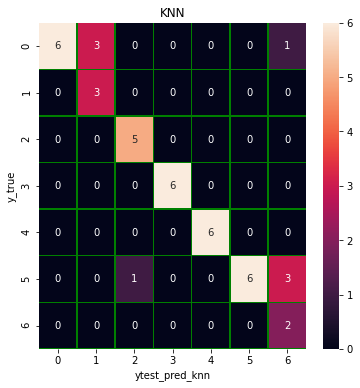

In [ ]:
# Confusion Matrix Plot
cm1 = confusion_matrix(ytest_pred_knn, ytest)
cm2 = confusion_matrix(ytest_pred_lda, ytest)
cm3 = confusion_matrix(ytest_pred_qda, ytest)
cm4 = confusion_matrix(ytest_pred_tree, ytest)
cm5 = confusion_matrix(ytest_pred_gnb, ytest)
cm6 = confusion_matrix(ytest_pred_svm, ytest)

plt.figure(figsize=(6, 6))
sns.heatmap(cm1,annot = True,linewidths=0.5,linecolor="green",fmt = ".0f")
plt.xlabel("ytest_pred_knn")
plt.ylabel("y_true")
plt.title('KNN')


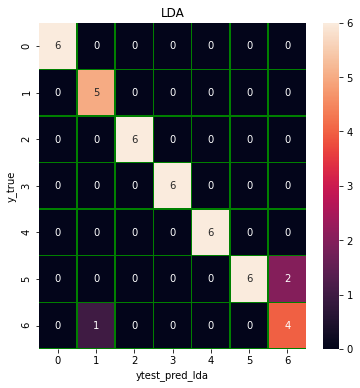

In [ ]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm2,annot = True,linewidths=0.5,linecolor="green",fmt = ".0f")
plt.xlabel("ytest_pred_lda")
plt.ylabel("y_true")
plt.title('LDA')
plt.savefig('CM_LDA_1.png', bbox_inches='tight')

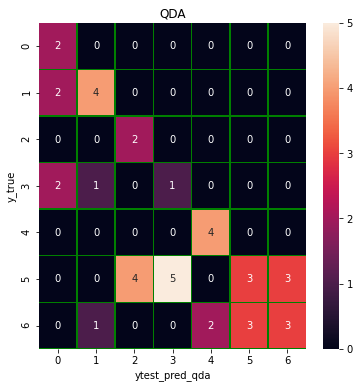

In [ ]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm3,annot = True,linewidths=0.5,linecolor="green",fmt = ".0f")
plt.xlabel("ytest_pred_qda")
plt.ylabel("y_true")
plt.title('QDA')
plt.savefig('QDA.png', bbox_inches='tight')
plt.show()

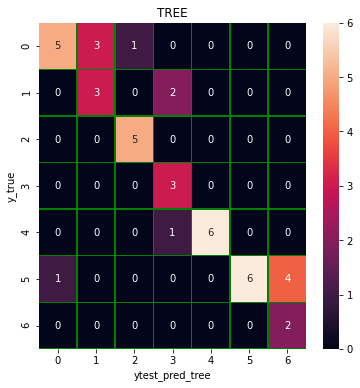

In [ ]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm4,annot = True,linewidths=0.5,linecolor="green",fmt = ".0f")
plt.xlabel("ytest_pred_tree")
plt.ylabel("y_true")
plt.title('TREE')
plt.show()

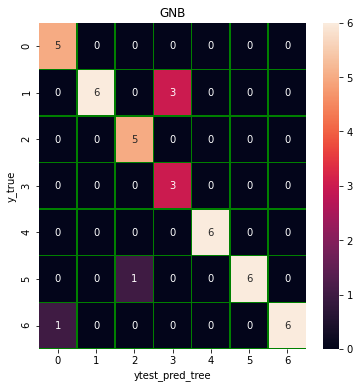

In [ ]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm5,annot = True,linewidths=0.5,linecolor="green",fmt = ".0f")
plt.xlabel("ytest_pred_tree")
plt.ylabel("y_true")
plt.title('GNB')
plt.savefig('GNB.png', bbox_inches='tight')
plt.show()

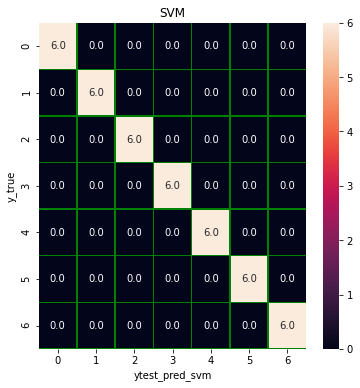

In [ ]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm6,annot = True,linewidths=0.5,linecolor="green",fmt = ".01f")
plt.xlabel("ytest_pred_svm")
plt.ylabel("y_true")
plt.title('SVM')
plt.savefig('CM_SVM1.png', bbox_inches='tight')
plt.show()


In [ ]:
kf = KFold(n_splits=10)
CS= cross_val_score(clf, Xreduced, y, cv=kf, scoring='accuracy')
CS

array([0.78571429, 0.85714286, 0.71428571, 1.        , 1.        ,
       1.        , 1.        , 0.71428571, 0.85714286, 0.57142857])

In [ ]:
np.mean(CS)

0.85

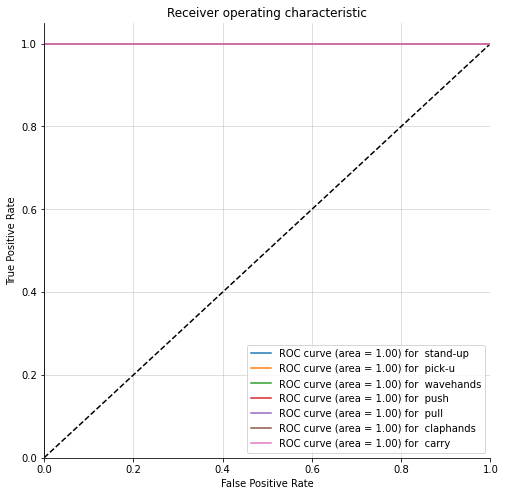

In [ ]:
plot_multiclass_roc(clf, Xtest, ytest, n_classes=7, figsize=(8, 8))

# Time-independent features

The principal idea is to use the mean and the variance of the features along all the frames to describe the whole movement. Another option is added, with the input 'mode' we can choose in how many subsets we want to divide the datase. 

In [ ]:
def variationFunction(features, i):
    global n
    lunghezza = len(features)
    n = int(lunghezza)
    if i==1:
        
        m = np.mean(features)
        dev = np.std(features)
        
        f= dev/m        
    
    elif i==2:
        m1 = np.mean(features[0: int(n/2)])
        dev1 = np.std(features[0: int(n/2)])
        
        m2 = np.mean(features[int(n/2): n+1])
        dev2 = np.std(features[int(n/2): n+1])
        
        f = [dev1/m1, dev2/m2]
    elif i==3: 
        
        m1 = np.mean(features[0: int(n/3)])
        dev1 = np.std(features[0: int(n/3)])
        
        m2 = np.mean(features[int(n/3): 2*(int(n/3))])
        dev2 = np.std(features[int(n/3):2*(int(n/3))])
        
        m3 = np.mean(features[2*(int(n/3)): n+1])
        dev3 = np.std(features[2*(int(n/3)):n+1])
        
        f = [dev1/m1, dev2/m2, dev3/m3]
        
    return f
    

In [ ]:
def featureExtractor(data,i):
    """distanceExtractor takes as an input the Dataset for a mocement and calculates 11 distances between joints.
    Finally put all the features of each frames in the same vector which corresponds to a row. The output 
    is a Dataframe where each row is a different experiment of the same action"""
    #Initialization of the Dataframe
    global outD
    outD = pd.DataFrame()
    outT = pd.DataFrame()
    outAll = pd.DataFrame()
   
    for j in data:    
        
        #separation of the body joints
        hipcenter=data[j].to_numpy()[:,0:3]
        spine=data[j].to_numpy()[:,3:6]
        shouldercenter=data[j].to_numpy()[:,6:9]
        head=data[j].to_numpy()[:,9:12]
        Lshow=data[j].to_numpy()[:,12:15]
        Rhow=data[j].to_numpy()[:,15:18]
        Lelbow=data[j].to_numpy()[:,18:21]
        Relbow=data[j].to_numpy()[:,21:24]
        Lwrist=data[j].to_numpy()[:,24:27]
        Rwrist=data[j].to_numpy()[:,27:30]
        Lhand=data[j].to_numpy()[:,30:33]
        Rhand=data[j].to_numpy()[:,33:36]
        Lhip=data[j].to_numpy()[:,36:39]
        Rhip=data[j].to_numpy()[:,39:42]
        Lknee=data[j].to_numpy()[:,42:45]
        Rknee=data[j].to_numpy()[:,45:48]
        Lancle=data[j].to_numpy()[:,48:51]
        Rancle=data[j].to_numpy()[:,51:54]
        Lfoot=data[j].to_numpy()[:,54:57]
        Rfoot=data[j].to_numpy()[:,57:60]
        
        #scale factor, distance between head and central hip
        f = np.mean(distance(head, hipcenter))        
        
        
        distance1 = distance(head, hipcenter)/f;
        distance2= distance (Lelbow, hipcenter)/f;
        distance3= distance (Relbow,hipcenter)/f;
        distance4= distance (Lhand, hipcenter)/f;
        distance5= distance (Rhand, hipcenter)/f;
        distance6= distance (Lknee, hipcenter)/f;
        distance7= distance (Rknee, hipcenter)/f;
        distance8= distance (Lfoot, hipcenter)/f;
        distance9= distance (Rfoot, hipcenter)/f;
        distance10= distance (Lhip, hipcenter)/f;
        distance11= distance (Rhip, hipcenter)/f;
        distance12 = distance(Lancle,hipcenter)/f
        distance13 = distance(Rancle, hipcenter)/f            
        distance14 = distance(Lhand, Rhand)/f;
        distance15= distance (Lfoot, Rfoot)/f;   
        distance16= distance(Lknee,Lelbow)/f;            
        distance17= distance (Rknee, Relbow)/f;            
        distance18= distance (Rancle, Lhand)/f;
        distance19= distance (Lancle, Rhand)/f;
        distance20= distance (Lancle, Lwrist)/f;
        distance21= distance (Rancle, Rwrist)/f;
        distance22= distance (Rhand, head)/f;
        distance23= distance (Lhand, head)/f;
        distance24= distance (Lelbow, Relbow)/f;            
        distance25= distance (Rknee, Lknee)/f;     
            
        global f1
        global f2
        f1 = variationFunction(distance1,i)
        f2 = variationFunction(distance2,i)
        f3 = variationFunction(distance3,i)
        f4 = variationFunction(distance4,i)
        f5 = variationFunction(distance5,i)
        f6 = variationFunction(distance6,i)
        f7 = variationFunction(distance7,i)
        f8 = variationFunction(distance8,i)
        f9 = variationFunction(distance9,i)
        f10 = variationFunction(distance10,i)
        f11 = variationFunction(distance11,i)
        f12 = variationFunction(distance12,i)
        f13 = variationFunction(distance13,i)
        f14 = variationFunction(distance14,i)
        f15 = variationFunction(distance15,i)
        f16 = variationFunction(distance16,i)
        f17 = variationFunction(distance17,i)
        f18 = variationFunction(distance18,i)
        f19 = variationFunction(distance19,i)
        f20 = variationFunction(distance20,i)
        f21 = variationFunction(distance21,i)
        f22 = variationFunction(distance22,i)
        f23 = variationFunction(distance23,i)
        f24 = variationFunction(distance24,i)
        f25 = variationFunction(distance25,i)
        
        
        if i==1:
            d = {'feature1':[f1], 'feature2':[f2], 'feature3':[f3], 'feature4':[f4], 'feature5':[f5], 'feature6':[f6], 'feature7':[f7], 'feature8':[f8],
                        'feature9':[f9], 'feature10':[f10], 'feature11':[f11], 'feature12':[f12], 'feature13':[f13],
             'feature14':[f14], 'feature15':[f15], 'feature16':[f16], 'feature17':[f17], 'feature18':[f18], 'feature19':[f19], 'feature20':[f20], 'feature21':[f21],
                        'feature22':[f22], 'feature23':[f23], 'feature24':[f24], 'feature25':[f25] }
       
        
            dataframeD = pd.DataFrame(data=d)
            outD = outD.append(dataframeD)
        else:
            data1 = np.concatenate((f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,
                                   f23,f24,f25))
            dataframeD = pd.DataFrame(data1).T
            outD = outD.append(dataframeD)
        
        
        #Areas features
        Area1 = TriseaCalculation(Relbow, Lelbow, hipcenter)/f            
        Area2 = TriseaCalculation(Rknee, Lknee, hipcenter)/f
            
        Area3 = TriseaCalculation(Relbow, Lknee, hipcenter)/f            
        Area4 = TriseaCalculation(Lelbow, Lknee, hipcenter)/f
            
        Area5 = TriseaCalculation(Rfoot, Lfoot, hipcenter)/f
        Area6 = TriseaCalculation(Lhand, Rhand, hipcenter)/f            
            
        Area7 = TriseaCalculation(Rknee, Lknee, hipcenter)/f
        Area8 = TriseaCalculation(Lwrist, Rwrist, hipcenter)/f      
            
        Area9 = TriseaCalculation(Relbow, Rhip, Rknee)/f
        Area10 = TriseaCalculation(Rknee, Lhip, Lfoot)/f
            
        Area11 = TriseaCalculation(hipcenter, Lelbow, Lhand)/f
            
        Area12 = TriseaCalculation(Rfoot, Rhand, Lhand)/f
        Area13 = TriseaCalculation(Lfoot, Rhand, Lhand)/f
            
        Area14 = TriseaCalculation(Lknee, Rhip, Rfoot)/f
        Area15 = TriseaCalculation(Lelbow, Lhip, Lknee)/f
        Area16 = TriseaCalculation(hipcenter, Relbow, Rhand)/f
        
        Area17 = TriseaCalculation(Relbow, Rhip, Lknee)/f
        
        Area18 = TriseaCalculation(Rknee, Rhip, Rfoot)/f
        Area19 = TriseaCalculation(hipcenter, Lelbow, Lhand)/f
        Area20 = TriseaCalculation(Lfoot, Lhand, Rfoot)/f
        Area21 = TriseaCalculation(Rfoot, Rhand, Rhip)/f
        Area22 = TriseaCalculation(Lknee, Lhip, Lfoot)/f
        Area23 = TriseaCalculation(Rknee, Rhip, Rfoot)/f
        Area24 = TriseaCalculation(Lknee, Lhip, Lfoot)/f
        Area25 = TriseaCalculation(Relbow, Rhip, Rfoot)/f
        
        fA1 = variationFunction(Area1,i)
        fA2 = variationFunction(Area2,i)
        fA3 = variationFunction(Area3,i)
        fA4 = variationFunction(Area4,i)
        fA5 = variationFunction(Area5,i)
        fA6 = variationFunction(Area6,i)
        fA7 = variationFunction(Area7,i)
        fA8 = variationFunction(Area8,i)
        fA9 = variationFunction(Area9,i)
        fA10 = variationFunction(Area10,i)
        fA11 = variationFunction(Area11,i)
        fA12 = variationFunction(Area12,i)
        fA13 = variationFunction(Area13,i)
        fA14 = variationFunction(Area14,i)
        fA15 = variationFunction(Area15,i)
        fA16 = variationFunction(Area16,i)
        fA17 = variationFunction(Area17,i)
        fA18 = variationFunction(Area18,i)
        fA19 = variationFunction(Area19,i)
        fA20 = variationFunction(Area20,i)
        fA21 = variationFunction(Area21,i)
        fA22 = variationFunction(Area22,i)
        fA23 = variationFunction(Area23,i)
        fA24 = variationFunction(Area24,i)
        fA25 = variationFunction(Area25,i)
        if i==1:
            dA = {'feature1':[fA1], 'feature2':[fA2], 'feature3':[fA3], 'feature4':[fA4], 'feature5':[fA5], 'feature6':[fA6], 'feature7':[fA7], 'feature8':[fA8],
                        'feature9':[fA9], 'feature10':[fA10], 'feature11':[fA11], 'feature12':[fA12], 'feature13':[fA13],
             'feature14':[fA14], 'feature15':[fA15], 'feature16':[fA16], 'feature17':[fA17], 'feature18':[fA18], 'feature19':[fA19], 'feature20':[fA20],
                 'feature21':[fA21], 'feature22':[fA22], 'feature23':[fA23], 'feature24':[fA24], 'feature25':[fA25]}
       
            dataframeT = pd.DataFrame(data=dA)
            outT = outT.append(dataframeT)
        
            dAll = {'f1':[f1], 'f2':[f2], 'f3':[f3], 'f4':[f4], 'f5':[f5], 'f6':[f6], 'f7':[f7], 'f8':[f8],
                        'f9':[f9], 'f10':[f10], 'f11':[f11], 'f12':[f12], 'f13':[f13],
             'f14':[f14], 'f15':[f15], 'f16':[f16], 'f17':[f17], 'f18':[f18], 'f19':[f19], 'f20':[f20], 'f21':[f21],
                        'f22':[f22], 'f23':[f23], 'f24':[f24], 'f25':[f25],'f26':[fA1], 'f27':[fA2], 'f28':[fA3], 'f29':[fA4], 'f30':[fA5], 'f31':[fA6], 'f32':[fA7], 'f33':[fA8],
                        'f34':[fA9], 'f35':[fA10], 'f36':[fA11], 'f37':[fA12], 'f38':[fA13],
             'f39':[fA14], 'f40':[fA15], 'f41':[fA16], 'f42':[fA17], 'f43':[fA18], 'f44':[fA19], 'f45':[fA20], 'f46':[fA21],
                   'f47':[fA22], 'f48':[fA23], 'f49':[fA24], 'f50':[fA25]}
            dataframeAll = pd.DataFrame(data=dAll)
            outAll = outAll.append(dataframeAll)
        
        else:
                
            dA = np.concatenate((fA1,fA2,fA3,fA4,fA5,fA6,fA7,fA8,fA9,fA10,fA11,fA12,fA13,fA14,fA15,fA16,fA17,fA18,fA19,fA20,
                                fA21, fA22, fA23, fA24, fA25))
            dataframeT = pd.DataFrame(dA).T
            outT = outT.append(dataframeT)
            
            
            dAll = np.concatenate((f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20, f21,
                                  f22, f23,f24,f25,fA1,fA2,fA3,fA4,fA5, fA6, fA7, fA8, fA9, fA10, fA11, fA12,fA13,
                                  fA14,fA15, fA16, fA17,fA18,fA19,fA20,  fA21, fA22, fA23, fA24, fA25))
            dataframeAll = pd.DataFrame(dAll).T
            outAll = outAll.append(dataframeAll)
        
    return outD*100, outT*100, outAll*100


In [ ]:
mode = 3
walkD, walkA, walkAll = featureExtractor(walk,mode)
standD, standA, standAll = featureExtractor(standUp,mode)
sitD, sitA, sitAll = featureExtractor(sitDown,mode)
pickD, pickA, pickAll = featureExtractor(pickUp,mode)
wavehandsD, wavehandsA, wavehandsAll= featureExtractor(wavehands,mode)
pushD, pushA, pushAll =  featureExtractor(push,mode)
pullD, pullA, pullAll= featureExtractor(pull,mode)
claphandsD, claphandsA, claphandsAll =  featureExtractor(claphands,mode)
carryD, carryA, carryAll = featureExtractor(carry,mode)
throwD, throwA, throwAll = featureExtractor(throw,mode)

In [ ]:
DataD = pd.concat([ standD, pickD, wavehandsD, pushD, pullD, claphandsD, carryD], ignore_index=True)
DataA = pd.concat([ standA, pickA, wavehandsA, pushA, pullA, claphandsA, carryA], ignore_index=True)
DataAll = pd.concat([ standAll, pickAll, wavehandsAll, pushAll, pullAll, claphandsAll, carryAll], ignore_index=True)
DataAll

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,2.252175,2.989130,1.229297,11.305230,5.558822,3.040674,12.427952,7.459351,2.886205,5.283407,...,0.877950,9.908574,3.315172,6.729986,7.059958,5.392788,0.877950,38.721990,4.520982,21.843638
1,0.434163,2.317139,1.648934,5.594114,8.281111,5.641528,2.767488,7.322564,6.904750,2.515035,...,3.197615,6.251583,9.150940,1.167916,7.263316,11.235971,3.197615,11.321265,10.876938,11.972392
2,2.434992,2.612015,1.857810,3.781673,5.378645,2.905257,5.301356,4.843402,3.379312,2.129570,...,1.954614,15.715836,9.971478,1.115195,17.982486,13.915197,1.954614,36.244189,77.051707,26.374007
3,0.910371,2.604323,1.109180,8.261507,15.827830,2.671664,7.972738,13.975185,1.526704,4.353489,...,7.100018,2.954209,3.944842,8.012770,2.350345,6.929628,7.100018,17.277873,13.538567,52.092539
4,2.428838,4.464303,2.382723,1.596731,21.099290,5.385420,3.449342,19.204509,4.753277,7.228099,...,3.038960,13.640231,6.269953,5.014520,11.724134,11.401427,3.038960,11.759358,21.170773,37.244959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,2.611075,1.435511,2.100111,15.287392,5.349901,20.210981,15.810988,2.237764,18.477915,6.499719,...,32.913533,22.327677,38.792408,44.838264,27.452953,31.887195,32.913533,17.013372,17.127286,16.732155
136,0.836303,3.182683,0.634505,4.124835,3.553245,11.495163,8.252834,3.601711,16.913846,7.384328,...,71.064167,28.321806,6.226682,67.784590,11.440054,6.267342,71.064167,11.712721,26.484890,63.150818
137,2.442824,1.647827,1.346654,9.626925,6.726416,3.512570,9.468438,6.220002,1.300689,25.275044,...,16.555599,20.346904,45.351733,16.922772,21.611200,40.802645,16.555599,26.519303,28.897052,41.956554
138,1.856108,1.891768,1.271013,17.028946,47.061793,6.266108,16.884407,41.408932,5.939830,2.975686,...,17.541836,22.592107,48.472792,18.210025,19.520599,42.863156,17.541836,19.597523,68.872043,55.214227


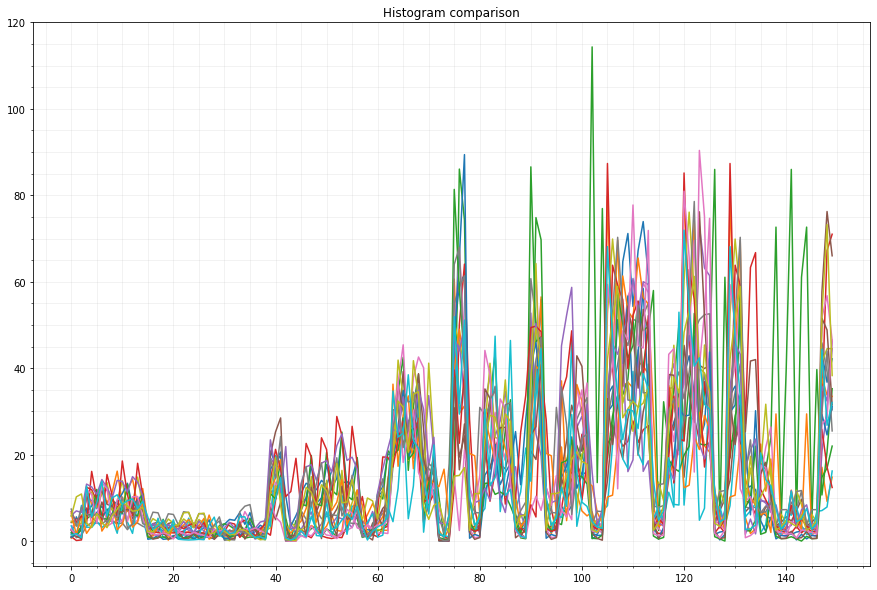

In [ ]:

plt.figure(figsize=[15,10])
plt.plot([i for i in range(150)],wavehandsAll.T)
plt.title('Histogram comparison')
plt.axis("on")
plt.grid(True, alpha=0.2)
plt.grid(True,which='minor', alpha=0.2)
plt.minorticks_on()
plt.savefig('wavehandsAll.png', bbox_inches='tight')
plt.show()

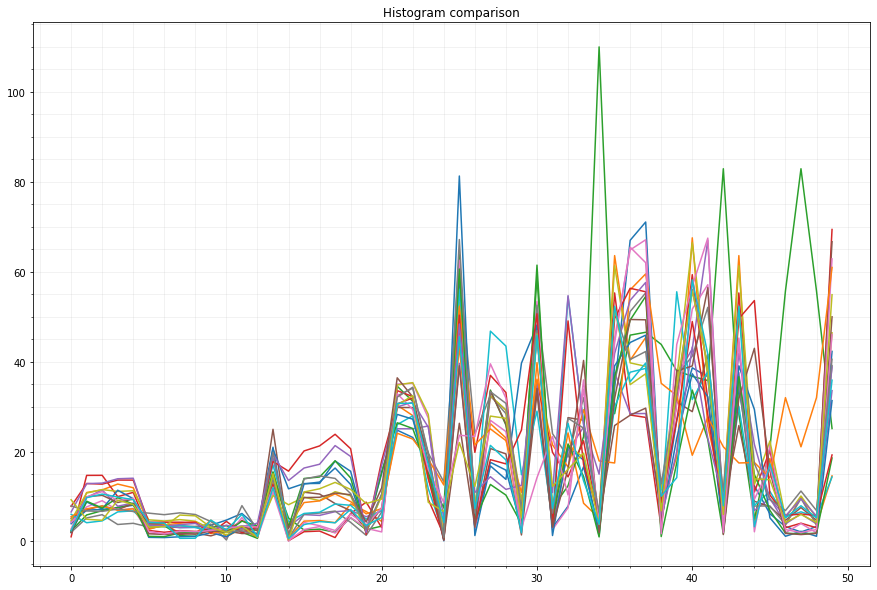

In [ ]:
plt.figure(figsize=[15,10])
plt.plot([i for i in range(50)],standAll.T)
plt.title('Histogram comparison')
plt.axis("on")
plt.grid(True, alpha=0.2)
plt.grid(True,which='minor', alpha=0.2)
plt.minorticks_on()
plt.savefig('standAll.png', bbox_inches='tight')
plt.show()

In [ ]:
classZero = np.zeros(20)
classOne = np.ones(20)
classTwo = 2*np.ones(20)
classThree = 3*np.ones(20)
classFour = 4*np.ones(20)
classFive = 5*np.ones(20)
classsix = 6*np.ones(20)
classseven = 7*np.ones(20)
classEight = 8*np.ones(20)
classNine = 9*np.ones(20)


labels= np.concatenate([classZero, classOne, classTwo, classThree, classFour, classFive , classsix ])



# Data all with mode1

In [ ]:
# split the data with 70% in each set
Xtrain, Xtest, ytrain, ytest = train_test_split(DataAll, y, random_state=0, train_size=0.7, stratify=y)

# SELECT CLASSIFIER
model_knn  = KNeighborsClassifier(n_neighbors=5)
model_lda  = LinearDiscriminantAnalysis( store_covariance=True)
model_qda  = QuadraticDiscriminantAnalysis(store_covariance=True)
model_tree = DecisionTreeClassifier()
model_gnb  = GaussianNB()
clf = svm.SVC()

# FIT the model on one set of data
model_knn.fit(Xtrain, ytrain)
model_lda.fit(Xtrain, ytrain)
model_qda.fit(Xtrain, ytrain)
model_tree.fit(Xtrain, ytrain)
model_gnb.fit(Xtrain, ytrain)
clf.fit(Xtrain, ytrain)



c:\users\lorenzo\appdata\local\programs\python\python39\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


SVC()

In [ ]:
# TEST evaluate the model on the second set of data
ytest_pred_knn  = model_knn.predict(Xtest)
ytest_pred_lda  = model_lda.predict(Xtest)
ytest_pred_qda  = model_qda.predict(Xtest)
ytest_pred_tree = model_tree.predict(Xtest)
ytest_pred_gnb  = model_gnb.predict(Xtest)
ytest_pred_svm = clf.predict(Xtest)

# Classification Report
print('KNN:')
print(classification_report(ytest, ytest_pred_knn))
print('LDA:')
print(classification_report(ytest, ytest_pred_lda))
print('QDA:')
print(classification_report(ytest, ytest_pred_qda))
print('TREE:')
print(classification_report(ytest, ytest_pred_tree))
print('GNB:')
print(classification_report(ytest, ytest_pred_gnb))
print('SVM:')
print(classification_report(ytest, ytest_pred_svm))


# Cross Validarion Scores
scores_knn  = cross_val_score(model_knn,  Xtest, ytest, cv=5)
scores_lda  = cross_val_score(model_lda,  Xtest, ytest, cv=5)
scores_qda  = cross_val_score(model_qda,  Xtest, ytest, cv=5)
scores_tree = cross_val_score(model_tree, Xtest, ytest, cv=5)
scores_gnb  = cross_val_score(model_gnb,  Xtest, ytest, cv=5)
scores_svm  = cross_val_score(clf,  Xtest, ytest, cv=5)

c:\users\lorenzo\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\lorenzo\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\lorenzo\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

KNN:
              precision    recall  f1-score   support

         0.0       0.75      1.00      0.86         6
         1.0       1.00      0.50      0.67         6
         2.0       0.86      1.00      0.92         6
         3.0       0.67      0.67      0.67         6
         4.0       1.00      0.67      0.80         6
         5.0       1.00      1.00      1.00         6
         6.0       0.62      0.83      0.71         6

    accuracy                           0.81        42
   macro avg       0.84      0.81      0.80        42
weighted avg       0.84      0.81      0.80        42

LDA:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         6
         1.0       1.00      0.33      0.50         6
         2.0       1.00      1.00      1.00         6
         3.0       0.20      0.17      0.18         6
         4.0       0.38      0.50      0.43         6
         5.0       0.86      1.00      0.92         6
         6.0  

c:\users\lorenzo\appdata\local\programs\python\python39\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\users\lorenzo\appdata\local\programs\python\python39\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\users\lorenzo\appdata\local\programs\python\python39\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\users\lorenzo\appdata\local\programs\python\python39\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\users\lorenzo\appdata\local\programs\python\python39\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [ ]:
# Cross Validation 
print("Accuracy KNN: %0.2f (+/- %0.2f)" % (scores_knn.mean(), scores_knn.std() ))
print("Accuracy LDA: %0.2f (+/- %0.2f)" % (scores_lda.mean(), scores_lda.std() ))
print("Accuracy QDA: %0.2f (+/- %0.2f)" % (scores_qda.mean(), scores_qda.std() ))
print("Accuracy TREE: %0.2f (+/- %0.2f)" % (scores_tree.mean(), scores_tree.std() ))
print("Accuracy GNB: %0.2f (+/- %0.2f)" % (scores_gnb.mean(), scores_gnb.std() ))
print("Accuracy SVM:%0.2f (+/- %0.2f)" % (scores_svm.mean(), scores_svm.std() ))



Accuracy KNN: 0.83 (+/- 0.19)
Accuracy LDA: 0.71 (+/- 0.17)
Accuracy QDA: 0.12 (+/- 0.07)
Accuracy TREE: 0.62 (+/- 0.16)
Accuracy GNB: 0.86 (+/- 0.09)
Accuracy SVM:0.84 (+/- 0.12)


Text(0.5, 1.0, 'KNN')

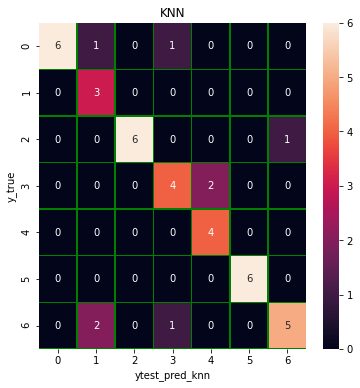

In [ ]:
# Confusion Matrix Plot
cm1 = confusion_matrix(ytest_pred_knn, ytest)
cm2 = confusion_matrix(ytest_pred_lda, ytest)
cm3 = confusion_matrix(ytest_pred_qda, ytest)
cm4 = confusion_matrix(ytest_pred_tree, ytest)
cm5 = confusion_matrix(ytest_pred_gnb, ytest)
cm6 = confusion_matrix(ytest_pred_svm, ytest)

plt.figure(figsize=(6, 6))
sns.heatmap(cm1,annot = True,linewidths=0.5,linecolor="green",fmt = ".0f")
plt.xlabel("ytest_pred_knn")
plt.ylabel("y_true")
plt.title('KNN')


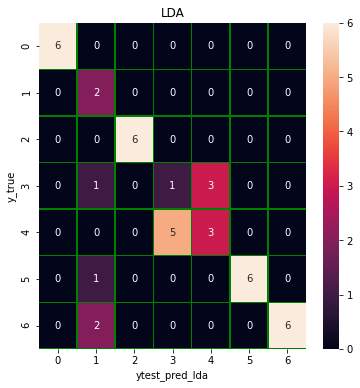

In [ ]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm2,annot = True,linewidths=0.5,linecolor="green",fmt = ".0f")
plt.xlabel("ytest_pred_lda")
plt.ylabel("y_true")
plt.title('LDA')
plt.savefig('CM_LDA_1.png', bbox_inches='tight')

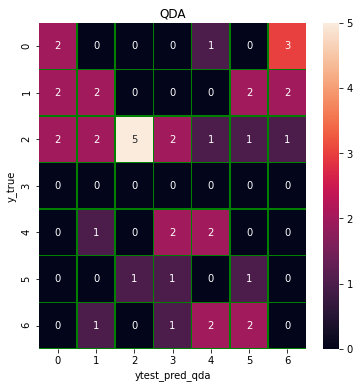

In [ ]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm3,annot = True,linewidths=0.5,linecolor="green",fmt = ".0f")
plt.xlabel("ytest_pred_qda")
plt.ylabel("y_true")
plt.title('QDA')
plt.savefig('QDA.png', bbox_inches='tight')
plt.show()

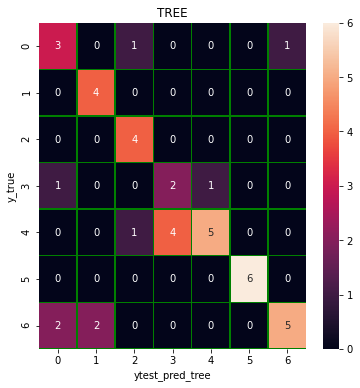

In [ ]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm4,annot = True,linewidths=0.5,linecolor="green",fmt = ".0f")
plt.xlabel("ytest_pred_tree")
plt.ylabel("y_true")
plt.title('TREE')
plt.show()

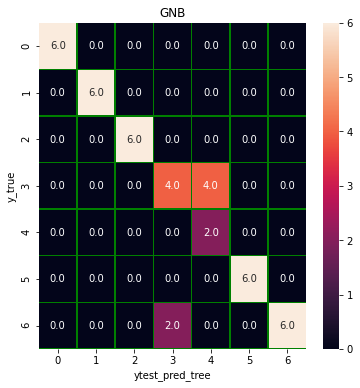

In [ ]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm5,annot = True,linewidths=0.5,linecolor="green",fmt = ".01f")
plt.xlabel("ytest_pred_tree")
plt.ylabel("y_true")
plt.title('GNB')
plt.savefig('GNB.png', bbox_inches='tight')
plt.show()

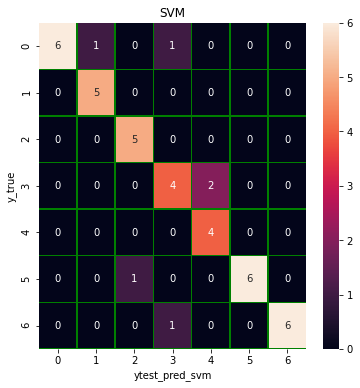

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm6,annot = True,linewidths=0.5,linecolor="green",fmt = ".0f")
plt.xlabel("ytest_pred_svm")
plt.ylabel("y_true")
plt.title('SVM')
plt.show()
plt.savefig('CM_SVM1.png', bbox_inches='tight')

In [ ]:
kf = KFold(n_splits=9)
CS= cross_val_score(model_gnb, DataAll, y, cv=kf, scoring='accuracy')
CS

array([0.6875    , 0.9375    , 0.9375    , 0.6875    , 0.1875    ,
       0.46666667, 0.93333333, 0.73333333, 0.8       ])

In [ ]:
np.mean(CS)

0.7078703703703703

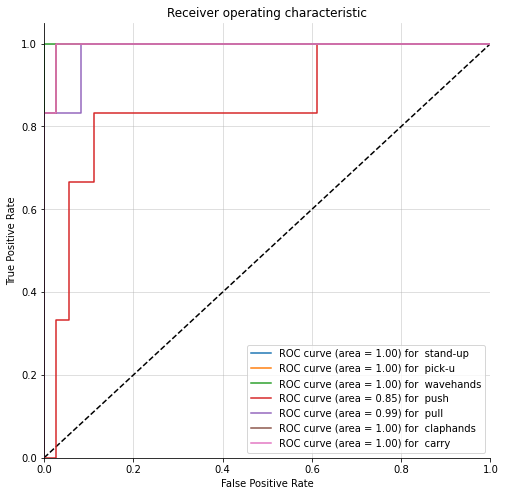

In [ ]:
plot_multiclass_roc(clf, Xtest, ytest, n_classes=7, figsize=(8, 8))

# DataAll with mode = 3

In [ ]:
mode = 3
walkD, walkA, walkAll = featureExtractor(walk,mode)
standD, standA, standAll = featureExtractor(standUp,mode)
sitD, sitA, sitAll = featureExtractor(sitDown,mode)
pickD, pickA, pickAll = featureExtractor(pickUp,mode)
wavehandsD, wavehandsA, wavehandsAll= featureExtractor(wavehands,mode)
pushD, pushA, pushAll =  featureExtractor(push,mode)
pullD, pullA, pullAll= featureExtractor(pull,mode)
claphandsD, claphandsA, claphandsAll =  featureExtractor(claphands,mode)
carryD, carryA, carryAll = featureExtractor(carry,mode)
throwD, throwA, throwAll = featureExtractor(throw,mode)

In [ ]:
DataAll = pd.concat([ standAll, pickAll, wavehandsAll, pushAll, pullAll, claphandsAll, carryAll], ignore_index=True)


In [ ]:
# split the data with 70% in each set
Xtrain, Xtest, ytrain, ytest = train_test_split(DataAll, y, random_state=0, train_size=0.7, stratify=y)

# SELECT CLASSIFIER
model_knn  = KNeighborsClassifier(n_neighbors=5)
model_lda  = LinearDiscriminantAnalysis( store_covariance=True)
model_qda  = QuadraticDiscriminantAnalysis(store_covariance=True)
model_tree = DecisionTreeClassifier()
model_gnb  = GaussianNB()
clf = svm.SVC()

# FIT the model on one set of data
model_knn.fit(Xtrain, ytrain)
model_lda.fit(Xtrain, ytrain)
model_qda.fit(Xtrain, ytrain)
model_tree.fit(Xtrain, ytrain)
model_gnb.fit(Xtrain, ytrain)
clf.fit(Xtrain, ytrain)

c:\users\lorenzo\appdata\local\programs\python\python39\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


SVC()

In [ ]:
# TEST evaluate the model on the second set of data
ytest_pred_knn  = model_knn.predict(Xtest)
ytest_pred_lda  = model_lda.predict(Xtest)
ytest_pred_qda  = model_qda.predict(Xtest)
ytest_pred_tree = model_tree.predict(Xtest)
ytest_pred_gnb  = model_gnb.predict(Xtest)
ytest_pred_svm = clf.predict(Xtest)

# Classification Report
print('KNN:')
print(classification_report(ytest, ytest_pred_knn))
print('LDA:')
print(classification_report(ytest, ytest_pred_lda))
print('QDA:')
print(classification_report(ytest, ytest_pred_qda))
print('TREE:')
print(classification_report(ytest, ytest_pred_tree))
print('GNB:')
print(classification_report(ytest, ytest_pred_gnb))
print('SVM:')
print(classification_report(ytest, ytest_pred_svm))


# Cross Validarion Scores
scores_knn  = cross_val_score(model_knn,  Xtest, ytest)
scores_lda  = cross_val_score(model_lda,  Xtest, ytest)
scores_qda  = cross_val_score(model_qda,  Xtest, ytest)
scores_tree = cross_val_score(model_tree, Xtest, ytest)
scores_gnb  = cross_val_score(model_gnb,  Xtest, ytest)
scores_svm  = cross_val_score(clf,  Xtest, ytest)

KNN:
              precision    recall  f1-score   support

         0.0       0.86      1.00      0.92         6
         1.0       1.00      0.50      0.67         6
         2.0       1.00      0.83      0.91         6
         3.0       0.71      0.83      0.77         6
         4.0       0.83      0.83      0.83         6
         5.0       0.71      0.83      0.77         6
         6.0       0.57      0.67      0.62         6

    accuracy                           0.79        42
   macro avg       0.81      0.79      0.78        42
weighted avg       0.81      0.79      0.78        42

LDA:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         6
         1.0       1.00      0.67      0.80         6
         2.0       0.80      0.67      0.73         6
         3.0       0.67      0.67      0.67         6
         4.0       0.86      1.00      0.92         6
         5.0       0.86      1.00      0.92         6
         6.0  

c:\users\lorenzo\appdata\local\programs\python\python39\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\users\lorenzo\appdata\local\programs\python\python39\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\users\lorenzo\appdata\local\programs\python\python39\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\users\lorenzo\appdata\local\programs\python\python39\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\users\lorenzo\appdata\local\programs\python\python39\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [ ]:
# Cross Validation 
print("Accuracy KNN: %0.2f (+/- %0.2f)" % (scores_knn.mean(), scores_knn.std() ))
print("Accuracy LDA: %0.2f (+/- %0.2f)" % (scores_lda.mean(), scores_lda.std() ))
print("Accuracy QDA: %0.2f (+/- %0.2f)" % (scores_qda.mean(), scores_qda.std() ))
print("Accuracy TREE: %0.2f (+/- %0.2f)" % (scores_tree.mean(), scores_tree.std() ))
print("Accuracy GNB: %0.2f (+/- %0.2f)" % (scores_gnb.mean(), scores_gnb.std() ))
print("Accuracy SVM:%0.2f (+/- %0.2f)" % (scores_svm.mean(), scores_svm.std() ))


Accuracy KNN: 0.62 (+/- 0.16)
Accuracy LDA: 0.71 (+/- 0.17)
Accuracy QDA: 0.14 (+/- 0.09)
Accuracy TREE: 0.74 (+/- 0.08)
Accuracy GNB: 0.76 (+/- 0.21)
Accuracy SVM:0.71 (+/- 0.18)


Text(0.5, 1.0, 'KNN')

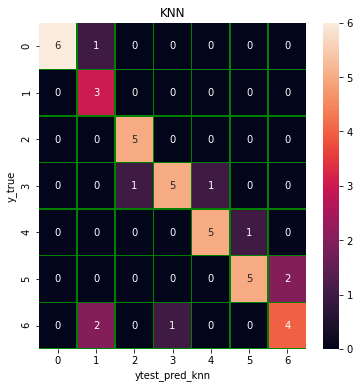

In [ ]:
# Confusion Matrix Plot
cm1 = confusion_matrix(ytest_pred_knn, ytest)
cm2 = confusion_matrix(ytest_pred_lda, ytest)
cm3 = confusion_matrix(ytest_pred_qda, ytest)
cm4 = confusion_matrix(ytest_pred_tree, ytest)
cm5 = confusion_matrix(ytest_pred_gnb, ytest)
cm6 = confusion_matrix(ytest_pred_svm, ytest)

plt.figure(figsize=(6, 6))
sns.heatmap(cm1,annot = True,linewidths=0.5,linecolor="green",fmt = ".0f")
plt.xlabel("ytest_pred_knn")
plt.ylabel("y_true")
plt.title('KNN')


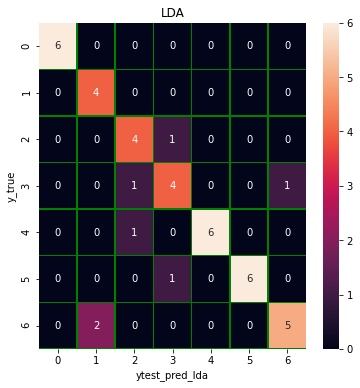

In [ ]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm2,annot = True,linewidths=0.5,linecolor="green",fmt = ".0f")
plt.xlabel("ytest_pred_lda")
plt.ylabel("y_true")
plt.title('LDA')
plt.savefig('CM_LDA_1.png', bbox_inches='tight')

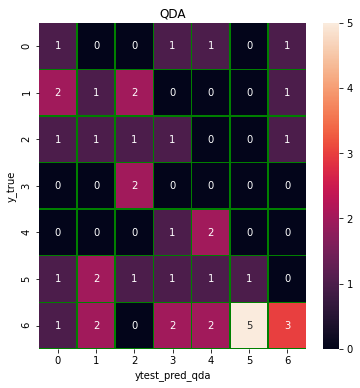

In [ ]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm3,annot = True,linewidths=0.5,linecolor="green",fmt = ".0f")
plt.xlabel("ytest_pred_qda")
plt.ylabel("y_true")
plt.title('QDA')
plt.savefig('QDA.png', bbox_inches='tight')
plt.show()

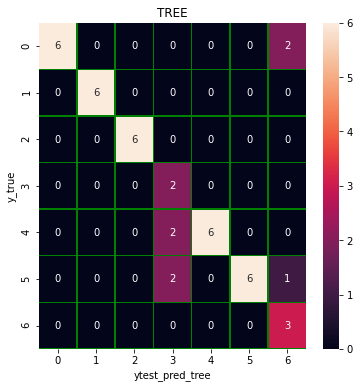

In [ ]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm4,annot = True,linewidths=0.5,linecolor="green",fmt = ".0f")
plt.xlabel("ytest_pred_tree")
plt.ylabel("y_true")
plt.title('TREE')
plt.show()

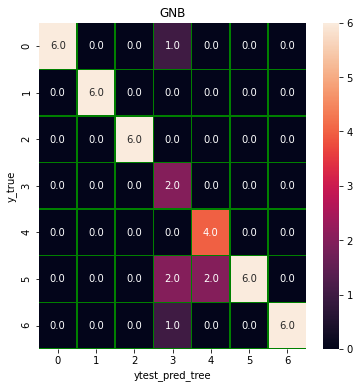

In [ ]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm5,annot = True,linewidths=0.5,linecolor="green",fmt = ".01f")
plt.xlabel("ytest_pred_tree")
plt.ylabel("y_true")
plt.title('GNB')
plt.savefig('GNB.png', bbox_inches='tight')
plt.show()

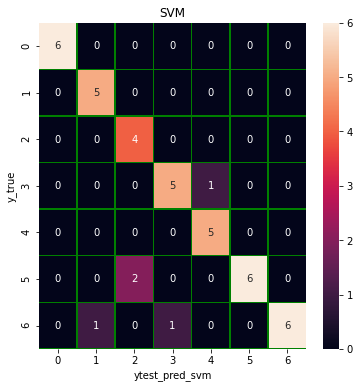

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm6,annot = True,linewidths=0.5,linecolor="green",fmt = ".0f")
plt.xlabel("ytest_pred_svm")
plt.ylabel("y_true")
plt.title('SVM')
plt.show()
plt.savefig('CM_SVM1.png', bbox_inches='tight')

In [ ]:
kf = KFold(n_splits=9)
CS= cross_val_score(model_lda, DataAll, y, cv=kf, scoring='accuracy')
CS

array([0.6875    , 0.5       , 0.4375    , 0.6875    , 0.3125    ,
       0.53333333, 0.53333333, 0.73333333, 0.6       ])

In [ ]:
np.mean(CS)

0.5583333333333332

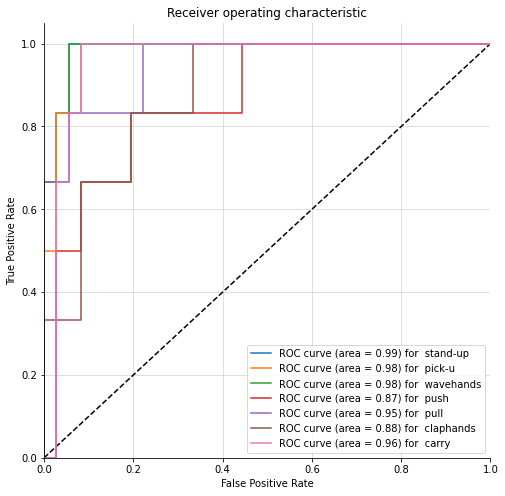

In [ ]:
plot_multiclass_roc(model_lda, Xtest, ytest, n_classes=7, figsize=(8, 8))

In [ ]:
#BIC ESTIMATION IN COMPLETE DATASET
from sklearn import mixture
import numpy as np

n_clusters = 7
NMAX = 10

bic = []
for kG in np.arange(1,NMAX+1):
    gmm = mixture.GaussianMixture(n_components=kG,covariance_type='full').fit(DataD)
    bic.append(gmm.bic(DataD))
    print(bic)
idx_winner = np.argmin(bic)
print('...and the winner is GMM model G = {}'.format(idx_winner+1))

[20592.786833809365]
[20592.786833809365, 20228.0578122069]
[20592.786833809365, 20228.0578122069, 18863.442535695885]
[20592.786833809365, 20228.0578122069, 18863.442535695885, 19481.534680138557]
[20592.786833809365, 20228.0578122069, 18863.442535695885, 19481.534680138557, 17103.3362310696]
[20592.786833809365, 20228.0578122069, 18863.442535695885, 19481.534680138557, 17103.3362310696, 16498.022813661904]
[20592.786833809365, 20228.0578122069, 18863.442535695885, 19481.534680138557, 17103.3362310696, 16498.022813661904, 15147.70620708501]
[20592.786833809365, 20228.0578122069, 18863.442535695885, 19481.534680138557, 17103.3362310696, 16498.022813661904, 15147.70620708501, 16312.227543804085]
[20592.786833809365, 20228.0578122069, 18863.442535695885, 19481.534680138557, 17103.3362310696, 16498.022813661904, 15147.70620708501, 16312.227543804085, 15851.267100270177]
[20592.786833809365, 20228.0578122069, 18863.442535695885, 19481.534680138557, 17103.3362310696, 16498.022813661904, 151